<a id="0"></a> <br>
 # Table of Contents  

1. [Introduction](#1)     
    1. [Business Problem](#2)
    2. [Analytical Methodology](#3)
    3. [Modelling Goal](#4)
1. [Data Modeling](#5)
    1. [Data Preparation](#6)
        1. [Exploratory Data Analysis](#7)
        2. [Data Cleaning and Feature Engineering](#8)          
    2. [Modelling](#9)
        1. [Data Preprocessing - Train and Test set](#10)
        2. [Modelling](#11)          
        3. [Findings](#12)
1. [Conclusion](#13)
1. [Group members' contribution](#14)


<a id="1"></a> 
# 1. Introduction

<a id="2"></a> 
## A. Business Problems
Home Credit aims to expand financial services to the unbanked population, where traditional credit history is limited or non-existent. To assess creditworthiness, they supplement loan applications with alternative data such as transaction records and telecom behavior.

The business objective is to predict the likelihood of loan default, where 0 indicates no default and 1 represents at least one late payment. Accurately predicting defaults will help Home Credit minimize losses and promote financial inclusion while ensuring responsible lending. This project aims to build a predictive model to assess clients' loan repayment ability using available data.

<a id="3"></a> 
## B. Analytical Methodology
Default risk prediction will be generated using supervised machine learning classification models. Historical loan application data will be downsampled and split into two sets, 80% for training and 20% for test. Multiple machine learning models will be built based on the trained dataset and test its performance on the test set. The models will analyze factors like applicant demographics, credit history, past loan performance and repayment behavior to predict the likeliness of clients’ default on loans. 

The notebook begins by exploring the application_train.csv file, which contains key demographic information about the applicants, such as age, income, along with their credit history and other significant documents. Next, we join additional behavioral datasets, including previous application (previous_application.csv) and credit history (bureau.csv, credit_card_balance.csv, installments_payments.csv), to enhance the prediction of default probability, particularly for individuals without a credit score.

Throughout the notebook, extensive data cleaning and feature engineering is performed to ensure the dataset is in optimal shape for analysis. Furthermore, the notebook focuses on identifying the most important predictors that influence the likelihood of defaulting. By carefully removing unnecessary rows and columns, the analysis reduces noise and enhances the model's overall efficiency

Finally, we will select the best-performing model and identify key factors, as well as how they impact default risks.

<a id="4"></a> 
## C. Modelling Goal
Ultimately, we aim to reduce the likelihood of default: by identifying the main predictors that are positively and negatively correlated with it

<a id="5"></a> 
# 2. Data Modelling

<a id="6"></a> 
## A. Data Preparation
To prepare the data for modeling, we perform the following:
- Exploratory Data Analysis
- Data Cleaning and Feature Engineering

<a id="7"></a> 
### a. Exploratory Data Analysis
In this section, we will examine the summary statistics of all datasets, with a deeper focus on application_train.csv and its target variable.

In [302]:
# importing packages for EDA
import pandas as pd
import numpy as np
import warnings

# Packages for plots
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde

#packages for preparing data
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler

#packages for modelling
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import roc_curve, auc
import lightgbm as lgb


In [304]:
application_train_df = pd.read_csv("application_train.csv")
application_test_df = pd.read_csv("application_test.csv")
credit_card_df = pd.read_csv("credit_card_balance.csv")
installment_df = pd.read_csv("installments_payments.csv")
previous_app_df = pd.read_csv("previous_application.csv")
bureau_df = pd.read_csv('bureau.csv')

#### Summary statistics

In [306]:
# application_train_df
summary = application_train_df.describe()
display(summary)
print(application_train_df.shape)

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307511.000000,307511.000000,307511.000000,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,307511.000000,307511.000000,307511.000000,...,307511.000000,307511.000000,307511.000000,307511.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000
mean,278180.518577,0.080729,0.417052,1.687979e+05,5.990260e+05,27108.573909,5.383962e+05,0.020868,-16036.995067,63815.045904,...,0.008130,0.000595,0.000507,0.000335,0.006402,0.007000,0.034362,0.267395,0.265474,1.899974
std,102790.175348,0.272419,0.722121,2.371231e+05,4.024908e+05,14493.737315,3.694465e+05,0.013831,4363.988632,141275.766519,...,0.089798,0.024387,0.022518,0.018299,0.083849,0.110757,0.204685,0.916002,0.794056,1.869295
min,100002.000000,0.000000,0.000000,2.565000e+04,4.500000e+04,1615.500000,4.050000e+04,0.000290,-25229.000000,-17912.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,189145.500000,0.000000,0.000000,1.125000e+05,2.700000e+05,16524.000000,2.385000e+05,0.010006,-19682.000000,-2760.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,278202.000000,0.000000,0.000000,1.471500e+05,5.135310e+05,24903.000000,4.500000e+05,0.018850,-15750.000000,-1213.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,367142.500000,0.000000,1.000000,2.025000e+05,8.086500e+05,34596.000000,6.795000e+05,0.028663,-12413.000000,-289.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
max,456255.000000,1.000000,19.000000,1.170000e+08,4.050000e+06,258025.500000,4.050000e+06,0.072508,-7489.000000,365243.000000,...,1.000000,1.000000,1.000000,1.000000,4.000000,9.000000,8.000000,27.000000,261.000000,25.000000


(307511, 122)


In [307]:
# credit_card_balance_df
summary = credit_card_df.describe()
display(summary)
print(credit_card_df.shape)

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,SK_DPD,SK_DPD_DEF
count,3.840312e+06,3.840312e+06,3.840312e+06,3.840312e+06,3.840312e+06,3.090496e+06,3.840312e+06,3.090496e+06,3.090496e+06,3.535076e+06,...,3.840312e+06,3.840312e+06,3.840312e+06,3.090496e+06,3.840312e+06,3.090496e+06,3.090496e+06,3.535076e+06,3.840312e+06,3.840312e+06
mean,1.904504e+06,2.783242e+05,-3.452192e+01,5.830016e+04,1.538080e+05,5.961325e+03,7.433388e+03,2.881696e+02,2.968805e+03,3.540204e+03,...,5.596588e+04,5.808881e+04,5.809829e+04,3.094490e-01,7.031439e-01,4.812496e-03,5.594791e-01,2.082508e+01,9.283667e+00,3.316220e-01
std,5.364695e+05,1.027045e+05,2.666775e+01,1.063070e+05,1.651457e+05,2.822569e+04,3.384608e+04,8.201989e+03,2.079689e+04,5.600154e+03,...,1.025336e+05,1.059654e+05,1.059718e+05,1.100401e+00,3.190347e+00,8.263861e-02,3.240649e+00,2.005149e+01,9.751570e+01,2.147923e+01
min,1.000018e+06,1.000060e+05,-9.600000e+01,-4.202502e+05,0.000000e+00,-6.827310e+03,-6.211620e+03,0.000000e+00,0.000000e+00,0.000000e+00,...,-4.233058e+05,-4.202502e+05,-4.202502e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.434385e+06,1.895170e+05,-5.500000e+01,0.000000e+00,4.500000e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.000000e+00,0.000000e+00,0.000000e+00
50%,1.897122e+06,2.783960e+05,-2.800000e+01,0.000000e+00,1.125000e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.500000e+01,0.000000e+00,0.000000e+00
75%,2.369328e+06,3.675800e+05,-1.100000e+01,8.904669e+04,1.800000e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.633911e+03,...,8.535924e+04,8.889949e+04,8.891451e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.200000e+01,0.000000e+00,0.000000e+00
max,2.843496e+06,4.562500e+05,-1.000000e+00,1.505902e+06,1.350000e+06,2.115000e+06,2.287098e+06,1.529847e+06,2.239274e+06,2.028820e+05,...,1.472317e+06,1.493338e+06,1.493338e+06,5.100000e+01,1.650000e+02,1.200000e+01,1.650000e+02,1.200000e+02,3.260000e+03,3.260000e+03


(3840312, 23)


In [308]:
# installment_df
summary = installment_df.describe()
display(summary)
print(installment_df.shape)

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
count,1.360540e+07,1.360540e+07,1.360540e+07,1.360540e+07,1.360540e+07,1.360250e+07,1.360540e+07,1.360250e+07
mean,1.903365e+06,2.784449e+05,8.566373e-01,1.887090e+01,-1.042270e+03,-1.051114e+03,1.705091e+04,1.723822e+04
std,5.362029e+05,1.027183e+05,1.035216e+00,2.666407e+01,8.009463e+02,8.005859e+02,5.057025e+04,5.473578e+04
min,1.000001e+06,1.000010e+05,0.000000e+00,1.000000e+00,-2.922000e+03,-4.921000e+03,0.000000e+00,0.000000e+00
25%,1.434191e+06,1.896390e+05,0.000000e+00,4.000000e+00,-1.654000e+03,-1.662000e+03,4.226085e+03,3.398265e+03
50%,1.896520e+06,2.786850e+05,1.000000e+00,8.000000e+00,-8.180000e+02,-8.270000e+02,8.884080e+03,8.125515e+03
75%,2.369094e+06,3.675300e+05,1.000000e+00,1.900000e+01,-3.610000e+02,-3.700000e+02,1.671021e+04,1.610842e+04
max,2.843499e+06,4.562550e+05,1.780000e+02,2.770000e+02,-1.000000e+00,-1.000000e+00,3.771488e+06,3.771488e+06


(13605401, 8)


In [309]:
# previous_app_df
summary = previous_app_df.describe()
display(summary)
print(previous_app_df.shape)

,SK_ID_PREV,SK_ID_CURR,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,HOUR_APPR_PROCESS_START,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,...,RATE_INTEREST_PRIVILEGED,DAYS_DECISION,SELLERPLACE_AREA,CNT_PAYMENT,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
count,1.670214e+06,1.670214e+06,1.297979e+06,1.670214e+06,1.670213e+06,7.743700e+05,1.284699e+06,1.670214e+06,1.670214e+06,774370.000000,...,5951.000000,1.670214e+06,1.670214e+06,1.297984e+06,997149.000000,997149.000000,997149.000000,997149.000000,997149.000000,997149.000000
mean,1.923089e+06,2.783572e+05,1.595512e+04,1.752339e+05,1.961140e+05,6.697402e+03,2.278473e+05,1.248418e+01,9.964675e-01,0.079637,...,0.773503,-8.806797e+02,3.139511e+02,1.605408e+01,342209.855039,13826.269337,33767.774054,76582.403064,81992.343838,0.332570
std,5.325980e+05,1.028148e+05,1.478214e+04,2.927798e+05,3.185746e+05,2.092150e+04,3.153966e+05,3.334028e+00,5.932963e-02,0.107823,...,0.100879,7.790997e+02,7.127443e+03,1.456729e+01,88916.115834,72444.869708,106857.034789,149647.415123,153303.516729,0.471134
min,1.000001e+06,1.000010e+05,0.000000e+00,0.000000e+00,0.000000e+00,-9.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00,-0.000015,...,0.373150,-2.922000e+03,-1.000000e+00,0.000000e+00,-2922.000000,-2892.000000,-2801.000000,-2889.000000,-2874.000000,0.000000
25%,1.461857e+06,1.893290e+05,6.321780e+03,1.872000e+04,2.416050e+04,0.000000e+00,5.084100e+04,1.000000e+01,1.000000e+00,0.000000,...,0.715645,-1.300000e+03,-1.000000e+00,6.000000e+00,365243.000000,-1628.000000,-1242.000000,-1314.000000,-1270.000000,0.000000
50%,1.923110e+06,2.787145e+05,1.125000e+04,7.104600e+04,8.054100e+04,1.638000e+03,1.123200e+05,1.200000e+01,1.000000e+00,0.051605,...,0.835095,-5.810000e+02,3.000000e+00,1.200000e+01,365243.000000,-831.000000,-361.000000,-537.000000,-499.000000,0.000000
75%,2.384280e+06,3.675140e+05,2.065842e+04,1.803600e+05,2.164185e+05,7.740000e+03,2.340000e+05,1.500000e+01,1.000000e+00,0.108909,...,0.852537,-2.800000e+02,8.200000e+01,2.400000e+01,365243.000000,-411.000000,129.000000,-74.000000,-44.000000,1.000000
max,2.845382e+06,4.562550e+05,4.180581e+05,6.905160e+06,6.905160e+06,3.060045e+06,6.905160e+06,2.300000e+01,1.000000e+00,1.000000,...,1.000000,-1.000000e+00,4.000000e+06,8.400000e+01,365243.000000,365243.000000,365243.000000,365243.000000,365243.000000,1.000000


(1670214, 37)


In [310]:
# bureau_df
summary = bureau_df.describe()
display(summary)
print(bureau_df.shape)

,SK_ID_CURR,SK_ID_BUREAU,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
count,1.716428e+06,1.716428e+06,1.716428e+06,1.716428e+06,1.610875e+06,1.082775e+06,5.919400e+05,1.716428e+06,1.716415e+06,1.458759e+06,1.124648e+06,1.716428e+06,1.716428e+06,4.896370e+05
mean,2.782149e+05,5.924434e+06,-1.142108e+03,8.181666e-01,5.105174e+02,-1.017437e+03,3.825418e+03,6.410406e-03,3.549946e+05,1.370851e+05,6.229515e+03,3.791276e+01,-5.937483e+02,1.571276e+04
std,1.029386e+05,5.322657e+05,7.951649e+02,3.654443e+01,4.994220e+03,7.140106e+02,2.060316e+05,9.622391e-02,1.149811e+06,6.774011e+05,4.503203e+04,5.937650e+03,7.207473e+02,3.258269e+05
min,1.000010e+05,5.000000e+06,-2.922000e+03,0.000000e+00,-4.206000e+04,-4.202300e+04,0.000000e+00,0.000000e+00,0.000000e+00,-4.705600e+06,-5.864061e+05,0.000000e+00,-4.194700e+04,0.000000e+00
25%,1.888668e+05,5.463954e+06,-1.666000e+03,0.000000e+00,-1.138000e+03,-1.489000e+03,0.000000e+00,0.000000e+00,5.130000e+04,0.000000e+00,0.000000e+00,0.000000e+00,-9.080000e+02,0.000000e+00
50%,2.780550e+05,5.926304e+06,-9.870000e+02,0.000000e+00,-3.300000e+02,-8.970000e+02,0.000000e+00,0.000000e+00,1.255185e+05,0.000000e+00,0.000000e+00,0.000000e+00,-3.950000e+02,0.000000e+00
75%,3.674260e+05,6.385681e+06,-4.740000e+02,0.000000e+00,4.740000e+02,-4.250000e+02,0.000000e+00,0.000000e+00,3.150000e+05,4.015350e+04,0.000000e+00,0.000000e+00,-3.300000e+01,1.350000e+04
max,4.562550e+05,6.843457e+06,0.000000e+00,2.792000e+03,3.119900e+04,0.000000e+00,1.159872e+08,9.000000e+00,5.850000e+08,1.701000e+08,4.705600e+06,3.756681e+06,3.720000e+02,1.184534e+08


(1716428, 17)


#### Exploring Target Variable

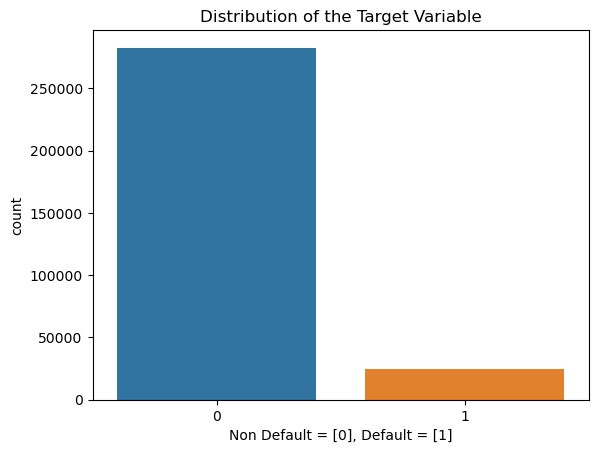

In [312]:
sns.countplot(x = application_train_df['TARGET'])
plt.title('Distribution of the Target Variable')
plt.xlabel('Non Default = [0], Default = [1]')
plt.show()

In [313]:
# Obtaining Target variable proportion
target_prop = round(application_train_df.value_counts(subset='TARGET', normalize=True),2)
print(target_prop)

print(f'The proportion of Non Defaulters [0] is {target_prop[0]}')
print(f'The proportion of Defaulters [1] is {target_prop[1]} ')


TARGET
0    0.92
1    0.08
Name: proportion, dtype: float64
The proportion of Non Defaulters [0] is 0.92
The proportion of Defaulters [1] is 0.08 


It appears we have a higher proportion of clients not having payment difficulties on loans compared to clients that have payment difficulties.
The above countplot illustrates this with a proportion of 92% for non default compared to 8% for default.

Additionally we have roughly 300,000 rows of data on the Train set with 122 columns
whereas we have 48,000 rows of data on the Test set with 121 columns (as it excludes the Target variable)

#### Exploring Certain Predictors

From team member's individual notebooks, we choose the following predictors' pairs to explore their relationships:
- CODE_GENDER vs TARGET
- NAME_CONTRACT_TYPE vs AMT_CREDIT by TARGET: how Cash loans and Revolving loans differ from each other
- EXT_SOURCE_1, EXT_SOURCE_2 and EXT_SOURCE_3

**CODE_GENDER vs TARGET**

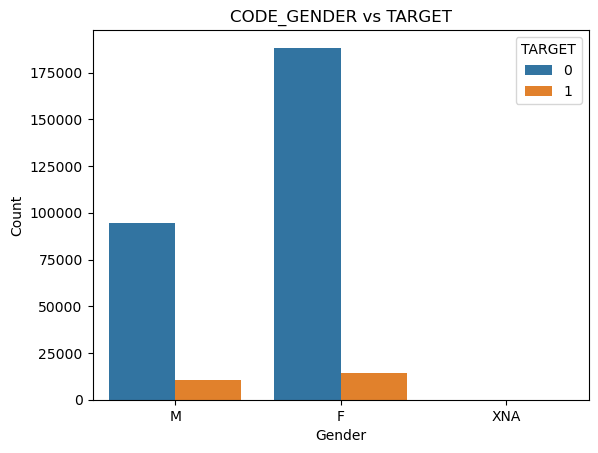

In [318]:
# Count plot for CODE_GENDER vs TARGET #### HUNGS FUNCTION - ADD THIS
sns.countplot(x='CODE_GENDER', hue='TARGET', data=application_train_df)
plt.title('CODE_GENDER vs TARGET')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()


Interestingly, males has a higher proportion of defaulting on loan than females

**NAME_CONTRACT_TYPE vs AMT_CREDIT by TARGET**

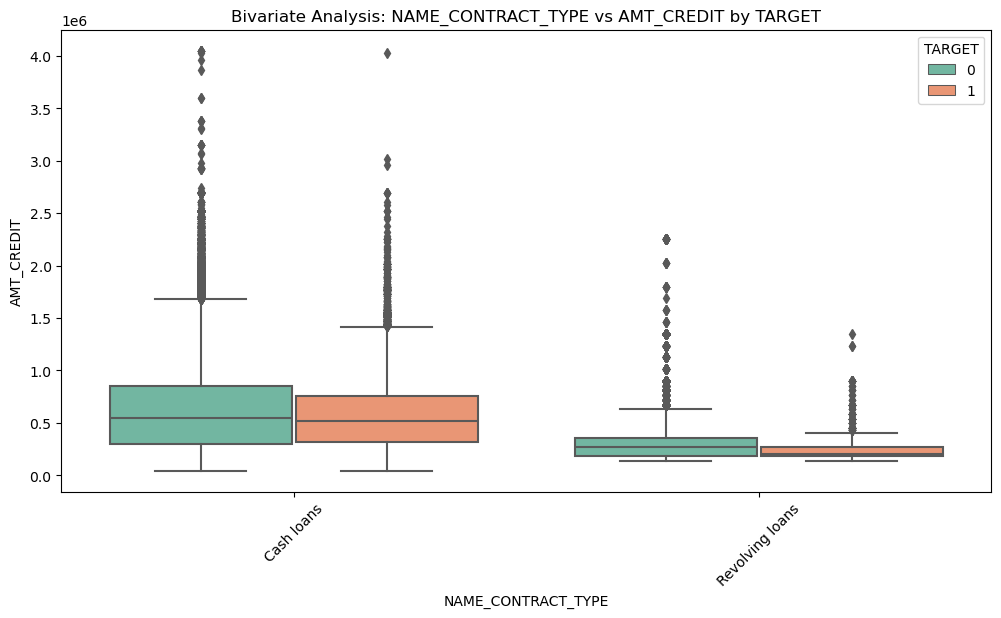

In [321]:
# Set up the figure size
plt.figure(figsize=(12, 6))

# Create a box plot with 'TARGET' as hue to separate the data
sns.boxplot(data=application_train_df, x='NAME_CONTRACT_TYPE', y='AMT_CREDIT', hue='TARGET', palette='Set2')

# Add title and labels
plt.title('Bivariate Analysis: NAME_CONTRACT_TYPE vs AMT_CREDIT by TARGET')
plt.xlabel('NAME_CONTRACT_TYPE')
plt.ylabel('AMT_CREDIT')

# Show the plot
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

The credit amount of loan for cash loans is much higher than revolving loans. Also, the non-defaulters usually borrow more than the defaulters.

**EXT_SOURCE_1, EXT_SOURCE_2, EXT_SOURCE_3**

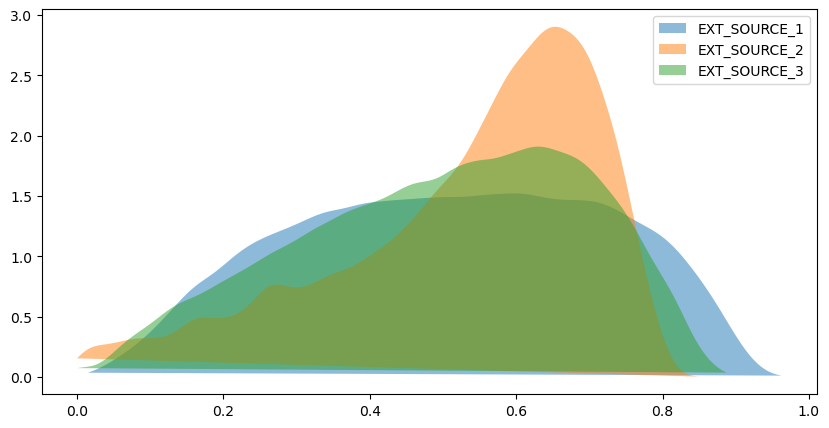

In [324]:
#Plotting the variation in the normalised credit score


# Replacing inf values with NaN
df_clean = application_train_df.copy()
df_clean.replace([np.inf, -np.inf], np.nan, inplace=True)

# Drop NaN values before plotting
df_clean.dropna(subset=['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3'], inplace=True)

# Plot using Scipy's gaussian_kde for the density plot
plt.figure(figsize=(10, 5))

# Create the KDE for each EXT_SOURCE column
for column in ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']:
    data = df_clean[column].dropna()
    kde = gaussian_kde(data)
    x_vals = np.linspace(data.min(), data.max(), 1000)
    y_vals = kde(x_vals)
    plt.fill(x_vals, y_vals, label=column, alpha=0.5)

# Add legend and show the plot
plt.legend()
plt.show()


From the plot, it is seen that,
EXT_SOURCE_2 has a concentrated distribution with a peak of 0.6, suggesting that this score is generally higher and less spread out compared to the other two sources which means it probably has more null values

<a id="8"></a> 

### b. Data Cleaning and Feature Engineering

In this section, we will conduct the 4 following data cleaning steps on each dataset with defined functions:
- Factorizing categorical columns:

For EXT_SOURCE columns, we seperate into different bins: 0 - 0.3, 0.3 - 0.6, 0.6 - 0.8, 0.8 - 1

For OWN_CAR_AGE, we seperate into "new", "old", "quite old", "very old" using quantiles. For those not having a car, "none" is assigned
- Dropping highly-correlated variables: remove one of the two variables in correlation pairs of more than 0.8 score according to the correlation matrix.
- Imputing missing values: impute mode for categorical columns and median for numerical columns

For OCCUPATION_TYPE, we impute missing values with "Others"

- Capping outliers at ±3 standard deviations for all numeric columns

**Creating Functions**

Creating a function to factorize EXT_SOURCE into bins:

In [330]:
# suppress warnings
warnings.filterwarnings('ignore')

# define the function for reducing memory usage when importing data
def reduce_memory_usage(df):

    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

In [343]:
def factorize_EXT_SOURCE(df):
    bins = [-1, 0, 0.3, 0.6, 0.8, 1.0]  # Define bin edges
    labels = ['None', 'Very Poor', 'Average', 'Good', 'Excellent']  # Category labels

    # Replace NaN with -1
    for col in ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']:
        df[col] = df[col].fillna(-1).astype('float32')

    # Binning into categories
    for col in ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']:
        df[col + '_Category'] = pd.cut(df[col], bins=bins, labels=labels, right=True, include_lowest=True)

    # Dropping original EXT_SOURCE columns
    df.drop(columns=['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3'], inplace=True)

    # Factorizing the categorical columns
    for col in ['EXT_SOURCE_1_Category', 'EXT_SOURCE_2_Category', 'EXT_SOURCE_3_Category']:
        df[col] = pd.factorize(df[col], sort=True)[0]

    print(f"Factorized Columns: {['EXT_SOURCE_1_Category', 'EXT_SOURCE_2_Category', 'EXT_SOURCE_3_Category']}")

    return df

Creating a function to change transform CAR_AGE into bins:

In [346]:
# Convert OWN_CAR_AGE to float32 to avoid float16 issues
def bin_CAR_AGE(df):

    df["OWN_CAR_AGE"] = df["OWN_CAR_AGE"].astype("float32")

    # Apply pd.cut() after ensuring the correct dtype
    # Apply pd.cut(), making a new feature
    df["CAR_AGE_BIN"] = pd.cut(df["OWN_CAR_AGE"],
                                 labels=["new", "old", "quite old", "very old"],
                                 bins=[0, df["OWN_CAR_AGE"].quantile(0.25),
                                       df["OWN_CAR_AGE"].median(),
                                       df["OWN_CAR_AGE"].quantile(0.75),
                                       df["OWN_CAR_AGE"].max()])

    # For rows that were originally missing, assign 'none' explicitly
    df["CAR_AGE_BIN"] = df["CAR_AGE_BIN"].cat.add_categories("none")  # Add "none" as a category
    df["CAR_AGE_BIN"] = df["CAR_AGE_BIN"].fillna("none")

    # Show the result
    print(df[['OWN_CAR_AGE', 'CAR_AGE_BIN']])

    # factorize
    df['CAR_AGE_BIN'] = pd.Categorical(df['CAR_AGE_BIN'], categories=["none", "new", "old", "quite old", "very old"], 
                                                   ordered=True) #order of value matter
    print(df['CAR_AGE_BIN'])

    df["CAR_AGE_BIN_Factorized"], _ = pd.factorize(df["CAR_AGE_BIN"])
    df.drop(columns=["CAR_AGE_BIN"], inplace=True)
    return df

A function that change 'NAME_CONTRACT_TYPE' from Revolving loans and Cash loans to 0, 1

In [349]:
def contract_type_factorized(df):
    # Convert to categorical type with ordered categories (Cash loans = 0, Revolving loans = 1)
    df['NAME_CONTRACT_TYPE'] = pd.Categorical(df['NAME_CONTRACT_TYPE'], 
                                              categories=['Cash loans', 'Revolving loans'], 
                                              ordered=True)

    # Convert to integer codes (ordinal encoding)
    df['NAME_CONTRACT_TYPE'] = df['NAME_CONTRACT_TYPE'].cat.codes.astype(int)

    return df

Creating a function to impute missing OCCUPATION_TYPE to Others:

In [352]:
#Change the missing occupations to others
def fill_OCCUPATION_col(df):
    df["OCCUPATION_TYPE"] = df["OCCUPATION_TYPE"].fillna("Others")
    return df

Creating a function to identify and drop missing values > 65%:

In [355]:
# filtering the data that has missing values > 65%
def dropna_over65(df):
    missing_values = df.isnull().sum().sort_values(ascending=False)
    missing_percent = (missing_values / len(df) * 100)

    missing_data_over_65 = missing_percent[missing_percent > 65]
    print(f'There are: {len(missing_data_over_65)} columns missing data over 65%')
    print(missing_data_over_65)

#dropping columns that have more than 65% null values
    df.drop(columns = missing_data_over_65.index, inplace=True)
    print('\n')
    print(f'Shape of the df after removing missing data over 65% : {df.shape}')
    return df

Creating a function to factorize categorical columns:

In [358]:
def factorize_cat_cols(df):
    cat_cols = df.select_dtypes(include='object').columns
    for col in cat_cols:
        df[col] = pd.factorize(df[col])[0]
    return cat_cols
    return df

Creating a function to drop highly correlation variables (to prevent multicolinearity):

In [361]:
# Drop highly-correlated numerical variables
# Identify pairs of features with correlation above a threshold
def redundant_data(df):
    threshold = 0.8
    to_drop = []  # List to store columns to drop
    numeric_columns = df.select_dtypes(include=['number']).columns
    correlation_matrix = df[numeric_columns].corr()

# Looping through the correlation matrix to find highly correlated pairs
    for i in range(len(correlation_matrix.columns)):
        for j in range(i):
            if abs(correlation_matrix.iloc[i, j]) > threshold:
                colname = correlation_matrix.columns[i]
                if colname not in to_drop:
                    to_drop.append(colname)

# Drop one column from each highly correlated pair
    to_drop = list(set(to_drop) & set(df.columns))

    # Drop columns
    df.drop(columns=to_drop, inplace=True)
    print(f"Dropped {len(to_drop)} redundant columns")
    print(f"The columns names that were dropped are :{to_drop}")
    print('\n')
    print(f"Shape of the dataset after removing multicolinearitly: {df.shape}")
    return df

Creating a function to impute remaining NAs:

In [364]:
def imputing_na(df):
    for col in df.columns:
        if not df[col].dtype == 'number':
            df[col] = df[col].fillna(df[col].mode()[0])
        else:
            df[col] = df[col].fillna(df[col].median())
    print("Imputed all na values")
    return df

Creating a function to fix the Outliers for CNT_CHILDREN:

In [367]:
#fixing CNT_CHILDREN
# We can see some people have 19 children according to the dataset. This is statistically rare.
# For any records have have > 6 children, they will be imputed to 6 children.
def standardize_children_col(df):
    df['CNT_CHILDREN'] = np.where(df['CNT_CHILDREN'] > 6, 6, df['CNT_CHILDREN'])
    df['CNT_CHILDREN'].value_counts().sort_index(ascending=True)
    return df

Creating a function to cap Outliers:

In [370]:
def cap_outliers_sd(df, threshold=3, exclude_columns=None):
    """
    Caps outliers at ±3 standard deviations for all numeric columns,
    except those in exclude_columns.

    Parameters:
    df (pd.DataFrame): The input DataFrame.
    threshold (float): Standard deviation threshold (default is 3).
    exclude_columns (list): List of column names to exclude from capping.

    Returns:
    pd.DataFrame: DataFrame with outliers capped for numeric columns only.
    """
    if exclude_columns is None:
        exclude_columns = []

    df_capped = df.copy()
    # Select only numeric columns
    numeric_columns = df.select_dtypes(include=[np.number]).columns

    for column in numeric_columns:
        if column in exclude_columns:
            continue  # Skip excluded column

        mean = df[column].mean()
        std_dev = df[column].std()

        lower_bound = mean - threshold * std_dev
        upper_bound = mean + threshold * std_dev

        df_capped[column] = df[column].clip(lower=lower_bound, upper=upper_bound)
        df_capped = df
    return df



**Application Train**

Running all functions for data cleaning on Application Train

In [374]:
application_clean_df = application_train_df.copy()
reduce_memory_usage(application_clean_df)
factorize_EXT_SOURCE(application_clean_df)
bin_CAR_AGE(application_clean_df)
contract_type_factorized(application_clean_df)
fill_OCCUPATION_col(application_clean_df)
dropna_over65(application_clean_df)

cat_cols_app = factorize_cat_cols(application_clean_df)

redundant_data(application_clean_df)
imputing_na(application_clean_df)
standardize_children_col(application_clean_df)

cap_outliers_sd(application_clean_df, exclude_columns = ['CNT_CHILDREN', 'TARGET'])

Memory usage of dataframe is 286.23 MB
Memory usage after optimization is: 92.38 MB
Decreased by 67.7%
Factorized Columns: ['EXT_SOURCE_1_Category', 'EXT_SOURCE_2_Category', 'EXT_SOURCE_3_Category']
        OWN_CAR_AGE CAR_AGE_BIN
0               NaN        none
1               NaN        none
2              26.0    very old
3               NaN        none
4               NaN        none
...             ...         ...
307506          NaN        none
307507          NaN        none
307508          NaN        none
307509          NaN        none
307510          NaN        none

[307511 rows x 2 columns]
0             none
1             none
2         very old
3             none
4             none
            ...   
307506        none
307507        none
307508        none
307509        none
307510        none
Name: CAR_AGE_BIN, Length: 307511, dtype: category
Categories (5, object): ['none' < 'new' < 'old' < 'quite old' < 'very old']
There are: 17 columns missing data over 65%
COMMONAREA

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,EXT_SOURCE_1_Category,EXT_SOURCE_2_Category,EXT_SOURCE_3_Category
0,100002,1,0.00000,0,0,0,0,202500.0,406597.5,24700.5,...,0.0,0.000000,0.0,0.0,0.0,0.0,1.0,1,1.0,1
1,100003,0,0.00000,1,0,1,0,270000.0,1293502.5,35698.5,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,2,3.0,0
2,100004,0,0.97574,0,1,0,0,67500.0,135000.0,6750.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0,2.0,3
3,100006,0,0.00000,1,0,0,0,135000.0,312682.5,29686.5,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0,3.0,0
4,100007,0,0.00000,0,0,0,0,121500.0,513000.0,21865.5,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0,2.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0,0.00000,0,0,1,0,157500.0,254700.0,27558.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,1,3.0,0
307507,456252,0,0.00000,1,0,0,0,72000.0,269550.0,12001.5,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0,1.0,0
307508,456253,0,0.00000,1,0,0,0,153000.0,677664.0,29979.0,...,0.0,0.234375,0.0,0.0,1.0,0.0,1.0,3,2.0,1
307509,456254,1,0.00000,1,0,0,0,171000.0,370107.0,20205.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0,2.0,3


In [375]:
application_clean_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 75 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   SK_ID_CURR                   307511 non-null  int32  
 1   TARGET                       307511 non-null  int8   
 2   NAME_CONTRACT_TYPE           307511 non-null  float64
 3   CODE_GENDER                  307511 non-null  int64  
 4   FLAG_OWN_CAR                 307511 non-null  int64  
 5   FLAG_OWN_REALTY              307511 non-null  int64  
 6   CNT_CHILDREN                 307511 non-null  int8   
 7   AMT_INCOME_TOTAL             307511 non-null  float32
 8   AMT_CREDIT                   307511 non-null  float64
 9   AMT_ANNUITY                  307511 non-null  float64
 10  NAME_TYPE_SUITE              307511 non-null  float64
 11  NAME_INCOME_TYPE             307511 non-null  float64
 12  NAME_EDUCATION_TYPE          307511 non-null  float64
 13 

In [376]:
application_clean_df['EXT_SOURCE_2_Category'].value_counts()

EXT_SOURCE_2_Category
3.000000    128595
2.000000    126145
1.000000     51549
0.046889       660
4.000000       562
Name: count, dtype: int64

**Bureau**

Since bureau is a time-series dataset on previous credits in Credit Bureau, we will aggregate on SK_ID_CURR to join with the application_train dataset.

Specifically, we conduct the following feature engineering:
- Number of active credits: the number of credit accounts that the applicant currently has. If the applicant has a high number of active credits, it could suggest they are under financial burden. In this case, we may doubt their ability to pay off the loans.
- Number of closed credits: the number of credit accounts that the applicant has paid off. If the applicant has a high number of closed credits (if paid off without default), it could suggest their ability to repay loans.
- Mean and Median DAYS_CREDIT_ENDDATE: the average loan term for the applicant. Long-term loans could indicate applicant's debt management over a long period of time
- Mean and Median REDIT_DAY_OVERDUE: the average number of days the applicant is overdue on their credit payments. High mean/median overdue days may indicate repayment struggles
- Mean and Median DURATION_OF_CREDIT: the average length of time an applicant has had a credit account or loan. A shorter credit duration might indicate a lack of experience with managing loans, or it might suggest financial stress if the borrower is taking out credit quickly to meet short-term needs.
- Mean and Median AMT_CREDIT_SUM: the average total amount of credit an applicant has taken out across all loans. A high mean/median total credit sum can indicate either the applicant has better financial standing or higher financial pressures, especially if they have trouble managing their payments across multiple accounts
- Mean and Median AMT_CREDIT_SUM_DEBT: the average total outstanding debt the applicant owes. If the mean or median debt amount is high, this indicates a burden of unpaid debts which is more prone to default.

We use both mean and median since mean is a better metric if the applicant has a low number of bureau credits, while median is a better metric if the applicant has a high  number of bureau credits.

However, after examining the relationships between target variable and these featured engineering variables, we find that they don't have high correlation. Therefore, these variables will not be used in the models.

In [57]:
bureau_df.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


In [58]:
dropna_over65(bureau_df)
factorize_cat_cols(bureau_df)

cap_outliers_sd(bureau_df, threshold=3, exclude_columns=None)

redundant_data(bureau_df)
imputing_na(bureau_df)

cap_outliers_sd(bureau_df, threshold=3, exclude_columns=None)

There are: 2 columns missing data over 65%
AMT_ANNUITY               71.473490
AMT_CREDIT_MAX_OVERDUE    65.513264
dtype: float64


Shape of the df after removing missing data over 65% : (1716428, 15)
Dropped 2 redundant columns
The columns names that were dropped are :['DAYS_CREDIT_UPDATE', 'DAYS_ENDDATE_FACT']


Shape of the dataset after removing multicolinearitly: (1716428, 13)
Imputed all na values


,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE
0,215354,5714462,0.0,0.0,-497,0.0,-153.000000,0.0,9.132300e+04,0.0,0.0,0.0,0.000000
1,215354,5714463,1.0,0.0,-208,0.0,1075.000000,0.0,2.250000e+05,171342.0,0.0,0.0,1.000000
2,215354,5714464,1.0,0.0,-203,0.0,528.000000,0.0,4.643235e+05,0.0,0.0,0.0,0.000000
3,215354,5714465,1.0,0.0,-203,0.0,15140.593063,0.0,9.000000e+04,0.0,0.0,0.0,1.000000
4,215354,5714466,1.0,0.0,-629,0.0,1197.000000,0.0,2.043704e+06,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1716423,259355,5057750,1.0,0.0,-44,0.0,-30.000000,0.0,1.125000e+04,11250.0,0.0,0.0,2.074841
1716424,100044,5057754,0.0,0.0,-2648,0.0,-2433.000000,0.0,3.813084e+04,0.0,0.0,0.0,0.000000
1716425,100044,5057762,0.0,0.0,-1809,0.0,-1628.000000,0.0,1.557000e+04,0.0,0.0,0.0,0.000000
1716426,246829,5057770,0.0,0.0,-1878,0.0,-1513.000000,0.0,3.600000e+04,0.0,0.0,0.0,0.000000


In [59]:
# Convert CREDIT_ACTIVE to binary indicators
bureau_df['closed_credit'] = (bureau_df['CREDIT_ACTIVE'] == 0).astype(int)
bureau_df['active_credit'] = (bureau_df['CREDIT_ACTIVE'] == 1).astype(int)

# Compute credit duration
bureau_df['credit_duration'] = bureau_df['DAYS_CREDIT_ENDDATE'] - bureau_df['DAYS_CREDIT']

# Aggregate statistics at SK_ID_CURR level
bureau_agg = bureau_df.groupby('SK_ID_CURR').agg(
    closed_credit_number=('closed_credit', 'sum'),
    active_credit_number=('active_credit', 'sum'),

    # Median values
    median_DAYS_CREDIT_ENDDATE=('DAYS_CREDIT_ENDDATE', 'median'),
    median_CREDIT_DAY_OVERDUE=('CREDIT_DAY_OVERDUE', 'median'),
    median_DURATION_OF_CREDIT=('credit_duration', 'median'),
    median_AMT_CREDIT_SUM=('AMT_CREDIT_SUM', 'median'),
    median_AMT_CREDIT_SUM_DEBT=('AMT_CREDIT_SUM_DEBT', 'median'),

    # Average values
    avg_DAYS_CREDIT_ENDDATE=('DAYS_CREDIT_ENDDATE', 'mean'),
    avg_CREDIT_DAY_OVERDUE=('CREDIT_DAY_OVERDUE', 'mean'),
    avg_DURATION_OF_CREDIT=('credit_duration', 'mean'),
    avg_AMT_CREDIT_SUM=('AMT_CREDIT_SUM', 'mean'),
    avg_AMT_CREDIT_SUM_DEBT=('AMT_CREDIT_SUM_DEBT', 'mean')
).reset_index()

# Display first 5 rows
bureau_agg.head()

,SK_ID_CURR,closed_credit_number,active_credit_number,median_DAYS_CREDIT_ENDDATE,median_CREDIT_DAY_OVERDUE,median_DURATION_OF_CREDIT,median_AMT_CREDIT_SUM,median_AMT_CREDIT_SUM_DEBT,avg_DAYS_CREDIT_ENDDATE,avg_CREDIT_DAY_OVERDUE,avg_DURATION_OF_CREDIT,avg_AMT_CREDIT_SUM,avg_AMT_CREDIT_SUM_DEBT
0,100001,4,3,-179.0,0.0,730.0,168345.00,0.0,82.428571,0.0,817.428571,207623.571429,85240.928571
1,100002,6,2,73.5,0.0,917.5,54130.50,0.0,3523.398266,0.0,4397.398266,108131.945625,30722.625000
2,100003,3,1,-480.0,0.0,725.5,92576.25,0.0,-544.500000,0.0,856.250000,254350.125000,0.000000
3,100004,2,0,-488.5,0.0,378.5,94518.90,0.0,-488.500000,0.0,378.500000,94518.900000,0.000000
4,100005,1,2,122.0,0.0,245.0,58500.00,25321.5,439.333333,0.0,630.000000,219042.000000,189469.500000


Running all functions for data cleaning on Bureau

In [61]:
bureau_agg.isnull().sum()

SK_ID_CURR                    0
closed_credit_number          0
active_credit_number          0
median_DAYS_CREDIT_ENDDATE    0
median_CREDIT_DAY_OVERDUE     0
median_DURATION_OF_CREDIT     0
median_AMT_CREDIT_SUM         0
median_AMT_CREDIT_SUM_DEBT    0
avg_DAYS_CREDIT_ENDDATE       0
avg_CREDIT_DAY_OVERDUE        0
avg_DURATION_OF_CREDIT        0
avg_AMT_CREDIT_SUM            0
avg_AMT_CREDIT_SUM_DEBT       0
dtype: int64

In [62]:
application_train_df_bureau = application_train_df.copy()

# Perform an inner join on SK_ID_CURR
merged_bureau = application_train_df_bureau.merge(bureau_agg, on='SK_ID_CURR', how='inner')

In [63]:
correlation = merged_bureau[['TARGET',
       'median_DAYS_CREDIT_ENDDATE', 'median_CREDIT_DAY_OVERDUE',
       'median_AMT_CREDIT_SUM', 'median_AMT_CREDIT_SUM_DEBT',
       'avg_DAYS_CREDIT_ENDDATE', 'avg_CREDIT_DAY_OVERDUE',
       'avg_AMT_CREDIT_SUM_DEBT']].corr()

# Keep only the 'TARGET' column, but show it as the first column
correlation_with_target = correlation[['TARGET']].drop(index='TARGET')
print(correlation_with_target)


                              TARGET
median_DAYS_CREDIT_ENDDATE  0.050471
median_CREDIT_DAY_OVERDUE   0.019912
median_AMT_CREDIT_SUM      -0.022305
median_AMT_CREDIT_SUM_DEBT  0.022906
avg_DAYS_CREDIT_ENDDATE     0.063329
avg_CREDIT_DAY_OVERDUE      0.031373
avg_AMT_CREDIT_SUM_DEBT     0.031543


Correlation is not used to conclude the top predictors. However, it can be used to preview the relationship between TARGET and other variables.
The Bureau predictors have low corelations with Target therefore it will be discarded.

**Credit Card Balance**

Since credit card is also a time-series data representing monthly balance snapshots of previous credit cards that the applicant has with Home Credit, we will aggregate it on SK_ID_PREV level.

Specifically, we conduct the following feature engineering:
- Duration: the number of months the credit card has been used. A short duration may indicate that the applicant is inexperienced in credit management
- Mean and Median AMT_BALANCE: the amount owed on the credit card. High balances coupled with insufficient income or financial strain can suggest a borrower at risk of default
- Mean and Median AMT_CREDIT_LIMIT_ACTUAL: the actual credit limit available to the borrower on the credit card. If the borrower has a high limit but consistently high balances, they may be over-leveraged, more prone to default.
- Mean and Median AMT_DRAWINGS_OTHER_CURRENT: the amount spent on other current purchases or withdrawals. High spending can indicate the borrower is heavily reliant on credit.
- Mean and Median AMT_DRAWINGS_POS_CURRENT: total amount spent using the Point-of-Sale (POS) system or for purchases at physical stores. Higher spending at POS can indicate a pattern of over-expenditure, especially if the borrower is unable to repay the amount within the month
- Mean and Median SK_DPD: the number of days the borrower is overdue on their credit card payments. It can be a strong predictor since a high number of days overdue can suggest the applicant has difficulty to repay the loan.
- Mean and Median SK_DPD_DEF: the number of days past due when a borrower has defaulted on a payment
- Max CNT_INSTALMENT_MATURE_CUM: if the applicant has a large number of matured installments, it could indicate a long-term history of missed or delayed payments. This may be an indicator of loan default.


Running all functions for data cleaning on Credit Card

In [67]:
credit_card_clean = credit_card_df.copy()
reduce_memory_usage(credit_card_clean)
dropna_over65(credit_card_clean)

cat_cols_cc = factorize_cat_cols(credit_card_clean)

redundant_data(credit_card_clean)
imputing_na(credit_card_clean)

cap_outliers_sd(credit_card_clean)


Memory usage of dataframe is 673.88 MB
Memory usage after optimization is: 289.33 MB
Decreased by 57.1%
There are: 0 columns missing data over 65%
Series([], dtype: float64)


Shape of the df after removing missing data over 65% : (3840312, 23)
Dropped 7 redundant columns
The columns names that were dropped are :['AMT_PAYMENT_TOTAL_CURRENT', 'CNT_DRAWINGS_POS_CURRENT', 'AMT_RECEIVABLE_PRINCIPAL', 'AMT_DRAWINGS_CURRENT', 'AMT_TOTAL_RECEIVABLE', 'AMT_INST_MIN_REGULARITY', 'AMT_RECIVABLE']


Shape of the dataset after removing multicolinearitly: (3840312, 16)
Imputed all na values


,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_PAYMENT_CURRENT,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970001,135000.0,0.000000,0.0,877.5,1800.000000,0.0,1.0,0.0,35.0,0.000000,0.0,0.0
1,2582071,363914,-1,63975.554688,45000.0,2250.000000,0.0,0.0,2250.000000,1.0,1.0,0.0,69.0,0.000000,0.0,0.0
2,1740877,371185,-7,31815.224609,450000.0,0.000000,0.0,0.0,2250.000000,0.0,0.0,0.0,30.0,0.000000,0.0,0.0
3,1389973,337855,-4,236572.109375,225000.0,2250.000000,0.0,0.0,11925.000000,1.0,1.0,0.0,10.0,0.000000,0.0,0.0
4,1891521,126868,-1,380692.582031,450000.0,0.000000,0.0,11547.0,27000.000000,0.0,1.0,0.0,101.0,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3840307,1036507,328243,-9,0.000000,45000.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
3840308,1714892,347207,-9,0.000000,45000.0,0.000000,0.0,0.0,1879.109985,0.0,0.0,0.0,23.0,0.000000,0.0,0.0
3840309,1302323,215757,-9,275784.968750,585000.0,80194.437012,0.0,0.0,104482.505859,2.0,2.0,0.0,18.0,0.000000,0.0,0.0
3840310,1624872,430337,-10,0.000000,450000.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


In [68]:
credit_card_clean = credit_card_clean.sort_values('SK_ID_PREV')
# Define aggregation functions with both median and mean
agg_funcs = {
    'SK_ID_CURR': 'first',  # Since SK_ID_CURR is the same for a given SK_ID_PREV
    'MONTHS_BALANCE': lambda x: abs(x.min() - x.max()),  # Duration calculation

    # Median and Mean for selected numerical features
    'AMT_BALANCE': ['median', 'mean'],
    'AMT_CREDIT_LIMIT_ACTUAL': ['median', 'mean'],
    'AMT_DRAWINGS_OTHER_CURRENT': ['median', 'mean'],
    'AMT_DRAWINGS_POS_CURRENT': ['median', 'mean'],
    'SK_DPD': ['median', 'mean'],
    'SK_DPD_DEF': ['median', 'mean'],

    # Max for installment count
    'CNT_INSTALMENT_MATURE_CUM': 'max',
}

# Perform aggregation
ccard_agg = credit_card_clean.groupby('SK_ID_PREV').agg(agg_funcs).reset_index()

# Flatten multi-level column names
ccard_agg.columns = ['_'.join(col).strip('_') if isinstance(col, tuple) else col for col in ccard_agg.columns]

# Rename the duration column explicitly
ccard_agg.rename(columns={'MONTHS_BALANCE_<lambda>': 'DURATION'}, inplace=True)

# Get the most recent NAME_CONTRACT_STATUS (based on max MONTHS_BALANCE)
latest_status = credit_card_clean.loc[credit_card_clean.groupby('SK_ID_PREV')['MONTHS_BALANCE'].idxmax(),
                                ['SK_ID_PREV', 'NAME_CONTRACT_STATUS']]

# Merge with the aggregated data
ccard_agg = ccard_agg.merge(latest_status, on='SK_ID_PREV', how='left')

# Rename columns to include 'MEDIAN_' and 'MEAN_' prefixes
ccard_agg.rename(columns={
    'AMT_BALANCE_median': 'MEDIAN_AMT_BALANCE',
    'AMT_BALANCE_mean': 'MEAN_AMT_BALANCE',
    'AMT_CREDIT_LIMIT_ACTUAL_median': 'MEDIAN_AMT_CREDIT_LIMIT_ACTUAL',
    'AMT_CREDIT_LIMIT_ACTUAL_mean': 'MEAN_AMT_CREDIT_LIMIT_ACTUAL',
    'AMT_DRAWINGS_OTHER_CURRENT_median': 'MEDIAN_AMT_DRAWINGS_OTHER_CURRENT',
    'AMT_DRAWINGS_OTHER_CURRENT_mean': 'MEAN_AMT_DRAWINGS_OTHER_CURRENT',
    'AMT_DRAWINGS_POS_CURRENT_median': 'MEDIAN_AMT_DRAWINGS_POS_CURRENT',
    'AMT_DRAWINGS_POS_CURRENT_mean': 'MEAN_AMT_DRAWINGS_POS_CURRENT',
    'SK_DPD_median': 'MEDIAN_SK_DPD',
    'SK_DPD_mean': 'MEAN_SK_DPD',
    'SK_DPD_DEF_median': 'MEDIAN_SK_DPD_DEF',
    'SK_DPD_DEF_mean': 'MEAN_SK_DPD_DEF'
}, inplace=True)

# Display result
ccard_agg.head()


,SK_ID_PREV,SK_ID_CURR_first,DURATION,MEDIAN_AMT_BALANCE,MEAN_AMT_BALANCE,MEDIAN_AMT_CREDIT_LIMIT_ACTUAL,MEAN_AMT_CREDIT_LIMIT_ACTUAL,MEDIAN_AMT_DRAWINGS_OTHER_CURRENT,MEAN_AMT_DRAWINGS_OTHER_CURRENT,MEDIAN_AMT_DRAWINGS_POS_CURRENT,MEAN_AMT_DRAWINGS_POS_CURRENT,MEDIAN_SK_DPD,MEAN_SK_DPD,MEDIAN_SK_DPD_DEF,MEAN_SK_DPD_DEF,CNT_INSTALMENT_MATURE_CUM_max,NAME_CONTRACT_STATUS
0,1000018,394447,4,44360.503906,74946.284375,45000.0,81000.000000,0.0,0.0,22827.330078,24078.995996,0.0,0.0,0.0,0.0,4.0,0.0
1,1000030,361282,7,48036.667969,55991.064209,78750.0,81562.500000,0.0,0.0,13381.650146,16694.938385,0.0,0.0,0.0,0.0,5.0,0.0
2,1000031,131335,15,2902.747559,52394.439392,144000.0,149625.000000,0.0,0.0,513.000000,9246.004898,0.0,0.0,0.0,0.0,10.0,0.0
3,1000035,436351,4,0.000000,0.000000,225000.0,225000.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,1000077,181153,10,0.000000,0.000000,135000.0,94090.909091,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


**Installment Payments**

Since installment payment dataset represents repayment history for the previously disbursed credits in Home Credit, we will aggregate it on SK_ID_PREV level.

Specifically, we conduct the following feature engineering:
- max_num_instalment_version: maximum number of installment versions. if a borrower frequently modifies or extends the number of installments in their loan repayment schedule, it can indicate difficulties in repaying the loan within the original terms
- total_instalment_number: total number of installment payments
- PAY_ONTIME: whether the payment is made ontime (1 - ontime, 2 - early, 3 - late)
- ENOUGH_PAY: whether the full amount is paid off (1 - the amount is paid in full, 2 - the amount is paid less, 3 - the amount is paid more)

Running all functions for data cleaning on Installments Payments

In [72]:
installment_clean_df = installment_df.copy()
reduce_memory_usage(installment_clean_df)
dropna_over65(installment_clean_df)

cat_cols_ip = factorize_cat_cols(installment_clean_df)

imputing_na(installment_clean_df)

cap_outliers_sd(installment_clean_df)


Memory usage of dataframe is 830.41 MB
Memory usage after optimization is: 311.40 MB
Decreased by 62.5%
There are: 0 columns missing data over 65%
Series([], dtype: float64)


Shape of the df after removing missing data over 65% : (13605401, 8)
Imputed all na values


,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6.0,-1180.0,-1187.0,6948.359863,6948.359863
1,1330831,151639,0.0,34.0,-2156.0,-2156.0,1716.525024,1716.525024
2,2085231,193053,2.0,1.0,-63.0,-63.0,25425.000000,25425.000000
3,2452527,199697,1.0,3.0,-2418.0,-2426.0,24350.130859,24350.130859
4,2714724,167756,1.0,2.0,-1383.0,-1366.0,2165.040039,2160.584961
...,...,...,...,...,...,...,...,...
13605396,2186857,428057,0.0,66.0,-1624.0,-91.0,67.500000,9000.000000
13605397,1310347,414406,0.0,47.0,-1539.0,-91.0,67.500000,9000.000000
13605398,1308766,402199,0.0,43.0,-7.0,-91.0,43737.433594,9000.000000
13605399,1062206,409297,0.0,43.0,-1986.0,-91.0,67.500000,9000.000000


In [73]:
installment_clean_df = installment_clean_df.sort_values('SK_ID_PREV')
# Add DIFF_PAY_VS_INSTAL_DAY
installment_clean_df['DIFF_PAY_VS_INSTAL_DAY'] = installment_clean_df['DAYS_INSTALMENT'] - installment_clean_df['DAYS_ENTRY_PAYMENT']

# Add PAY_ONTIME
#1 <- ontime, 2 <- early, 3 <- late
installment_clean_df['PAY_ONTIME'] = installment_clean_df['DIFF_PAY_VS_INSTAL_DAY'].apply(
    lambda x: 1 if x == 0 else (2 if x > 0 else 3)
)
installment_clean_df['PAY_ONTIME']

# Add DIFF_PAY_VS_INSTAL_AMT
installment_clean_df['DIFF_PAY_VS_INSTAL_AMT'] = installment_clean_df['AMT_INSTALMENT'] - installment_clean_df['AMT_PAYMENT']

# Add ENOUGH_PAY
# 1 <- enough, 2 <- less_pay, 3 <- more_pay
installment_clean_df['ENOUGH_PAY'] = installment_clean_df['DIFF_PAY_VS_INSTAL_AMT'].apply(
    lambda x: 1 if x == 0 else (2 if x > 0 else 3)
)

#dropping the other columns
installment_clean_df.drop(columns = ['DIFF_PAY_VS_INSTAL_DAY'], inplace = True)
installment_clean_df.drop(columns = ['DIFF_PAY_VS_INSTAL_AMT'], inplace = True)

# Display the updated DataFrame
installment_clean_df.head()

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT,PAY_ONTIME,ENOUGH_PAY
512588,1000001,158271,1.0,1.0,-268.0,-294.0,6404.310059,6404.310059,2,1
2159480,1000001,158271,2.0,2.0,-238.0,-244.0,62039.113281,62039.113281,2,1
3411021,1000002,101962,1.0,3.0,-1540.0,-1559.0,6264.000000,6264.000000,2,1
1214732,1000002,101962,1.0,1.0,-1600.0,-1611.0,6264.000000,6264.000000,2,1
1006868,1000002,101962,2.0,4.0,-1510.0,-1554.0,18443.564453,18443.564453,2,1


In [74]:
# Use .mode() only once per column and convert to a dictionary for fast lookup
pay_ontime_mode = installment_clean_df.groupby('SK_ID_PREV')['PAY_ONTIME'].agg(lambda x: pd.Series.mode(x)[0] if not x.mode().empty else None)
enough_pay_mode = installment_clean_df.groupby('SK_ID_PREV')['ENOUGH_PAY'].agg(lambda x: pd.Series.mode(x)[0] if not x.mode().empty else None)

# Perform groupby and aggregation for other columns
instalment_agg = installment_clean_df.groupby('SK_ID_PREV').agg(
    SK_ID_CURR=('SK_ID_CURR', 'first'),
    max_num_instalment_version=('NUM_INSTALMENT_VERSION', 'max'),
    total_instalment_number=('NUM_INSTALMENT_NUMBER', 'max')
).reset_index()

# Merge pre-computed modes into the aggregated DataFrame
instalment_agg = instalment_agg.merge(pay_ontime_mode.rename('PAY_ONTIME'), on='SK_ID_PREV')
instalment_agg = instalment_agg.merge(enough_pay_mode.rename('ENOUGH_PAY'), on='SK_ID_PREV')

# Display the result
instalment_agg.head()



,SK_ID_PREV,SK_ID_CURR,max_num_instalment_version,total_instalment_number,PAY_ONTIME,ENOUGH_PAY
0,1000001,158271,2.0,2.0,2,1
1,1000002,101962,2.0,4.0,2,1
2,1000003,252457,1.0,3.0,2,1
3,1000004,260094,2.0,7.0,2,1
4,1000005,176456,1.0,10.0,2,1


In [75]:
#write to csv so that we dont have to do the aggregation everytime
instalment_agg.to_csv("installment_agg.csv", index = False)

**Previous Application**

Since previous application dataset represents all previous applications for Home Credit loans of clients who have loans, we will aggregate it on SK_ID_CURR level. Next, we will join previous application with credit card balance and installment payment on SK_ID_PREV.

Specifically, we conduct the following feature engineering:
- number of SK_ID_PREV
- mode NAME_CONTRACT_TYPE
- mode NAME_CASH_LOAN_PURPOSE
- mode NAME_PAYMENT_TYPE
- median CNT_PAYMENT
- median MEDIAN_AMT_BALANCE
- median MEDIAN_AMT_CREDIT_LIMIT_ACTUAL
- median MEDIAN_AMT_DRAWINGS_OTHER_CURRENT
- median MEDIAN_AMT_DRAWINGS_POS_CURRENT
- median MEDIAN_SK_DPD
- median MEDIAN_SK_DPD_DEF
- mean max_num_instalment_version
- mean total_instalment_number
- mode PAY_ONTIME
- mode ENOUGH_PAY
- mean MEAN_AMT_BALANCE
- mean MEAN_AMT_CREDIT_LIMIT_ACTUAL
- mean MEAN_AMT_DRAWINGS_OTHER_CURRENT
- mean MEAN_AMT_DRAWINGS_POS_CURRENT
- mean MEAN_SK_DPD

In [78]:
# Drop rows where contract type is "XNA"
previous_app_df = previous_app_df[previous_app_df['NAME_CONTRACT_TYPE'] != 'XNA']

# For 'NAME_CONTRACT_TYPE' being 'Cash loans' or 'Revolving loans', fill NAs with 0
previous_app_df.loc[previous_app_df['NAME_CONTRACT_TYPE'].isin(['Cash loans', 'Revolving loans']), 'AMT_APPLICATION'] = previous_app_df.loc[previous_app_df['NAME_CONTRACT_TYPE'].isin(['Cash loans', 'Revolving loans']), 'AMT_APPLICATION'].fillna(0)

# For 'NAME_CONTRACT_TYPE' being 'Consumer loans', fill missing values in 'AMT_APPLICATION' with the median
consumer_loan_median = previous_app_df[previous_app_df['NAME_CONTRACT_TYPE'] == 'Consumer loans']['AMT_APPLICATION'].median()
previous_app_df.loc[previous_app_df['NAME_CONTRACT_TYPE'] == 'Consumer loans', 'AMT_APPLICATION'] = previous_app_df.loc[previous_app_df['NAME_CONTRACT_TYPE'] == 'Consumer loans', 'AMT_APPLICATION'].fillna(consumer_loan_median)

# Fill missing values in 'NAME_TYPE_SUITE' with 'Other'
previous_app_df['NAME_TYPE_SUITE'].fillna('Other', inplace=True)

# Drop the 'PRODUCT_COMBINATION' column
previous_app_df.drop(columns=['PRODUCT_COMBINATION'], inplace=True)

Running all functions for data cleaning on Previous Application

In [80]:
previous_app_clean = previous_app_df.copy()
reduce_memory_usage(previous_app_clean)
dropna_over65(previous_app_clean)

cat_cols_prev = factorize_cat_cols(previous_app_clean)

redundant_data(previous_app_clean)
imputing_na(previous_app_clean)

cap_outliers_sd(previous_app_clean)
previous_app_clean.head()


Memory usage of dataframe is 471.38 MB
Memory usage after optimization is: 308.95 MB
Decreased by 34.5%
There are: 2 columns missing data over 65%
RATE_INTEREST_PRIVILEGED    99.643625
RATE_INTEREST_PRIMARY       99.643625
dtype: float64


Shape of the df after removing missing data over 65% : (1669868, 34)
Dropped 6 redundant columns
The columns names that were dropped are :['AMT_CREDIT', 'DAYS_LAST_DUE_1ST_VERSION', 'NAME_PORTFOLIO', 'DAYS_TERMINATION', 'AMT_APPLICATION', 'AMT_GOODS_PRICE']


Shape of the dataset after removing multicolinearitly: (1669868, 28)
Imputed all na values


,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_DOWN_PAYMENT,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,...,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,0,1730.430054,0.0,0,15.0,0.0,1.0,0.0,...,0,0.0,35.0,0.0,12.0,0,365243.0,-42.0,-42.0,0.0
1,2802425,108129,1,25188.615234,0.0,1,11.0,0.0,1.0,0.0,...,1,1.0,-1.0,1.0,36.0,1,365243.0,-134.0,365243.0,1.0
2,2523466,122040,1,15060.735352,0.0,2,11.0,0.0,1.0,0.0,...,1,2.0,-1.0,1.0,12.0,2,365243.0,-271.0,365243.0,1.0
3,2819243,176158,1,47041.335938,0.0,3,7.0,0.0,1.0,0.0,...,1,2.0,-1.0,1.0,12.0,0,365243.0,-482.0,-182.0,1.0
4,1784265,202054,1,31924.394531,0.0,1,9.0,0.0,1.0,0.0,...,2,2.0,-1.0,1.0,24.0,2,365243.0,365243.0,365243.0,0.0


In [81]:
previous_app_clean.shape

(1669868, 28)

Joining installment payment and credit card balance on SK_ID_PREV

In [83]:
installment_agg = pd.read_csv("installment_agg.csv")

In [84]:
# Perform left join with ccard_agg using SK_ID_PREV
joined_prev = previous_app_df.merge(ccard_agg, on="SK_ID_PREV", how="left")

# Perform left join with instalment_agg using SK_ID_PREV
joined_prev = joined_prev.merge(instalment_agg, on="SK_ID_PREV", how="left")

In [85]:
# Drop the duplicate SK_ID_CURR columns
joined_prev = joined_prev.drop(columns=["SK_ID_CURR_first", "SK_ID_CURR_y"], errors = 'ignore')
joined_prev = joined_prev.drop(columns=["NAME_CONTRACT_STATUS_y"], errors = 'ignore')

Perform aggregation after joining previous application, installment payment and credit card balance on SK_ID_PREV

In [87]:
joined_prev.sort_values('SK_ID_CURR_x')
# Explicitly convert numeric columns
numeric_cols = [
    "AMT_ANNUITY",
    "CNT_PAYMENT"
]

for col in numeric_cols:
    joined_prev[col] = pd.to_numeric(joined_prev[col], errors='coerce')

# Simplified aggregation dictionary (added mean directly to agg_dict)
agg_dict = {
    "SK_ID_PREV": "count",
    "AMT_ANNUITY": ["median", "sum"],
    "CNT_PAYMENT": "median",
    "NAME_CONTRACT_TYPE": lambda x: x.mode().iloc[0] if not x.mode().empty else None,
    "NAME_CASH_LOAN_PURPOSE": lambda x: x.mode().iloc[0] if not x.mode().empty else None,
    "NAME_PAYMENT_TYPE": lambda x: x.mode().iloc[0] if not x.mode().empty else None,
    "MEDIAN_AMT_BALANCE": "median",
    "MEDIAN_AMT_CREDIT_LIMIT_ACTUAL": "median",
    "MEDIAN_AMT_DRAWINGS_OTHER_CURRENT": "median",
    "MEDIAN_AMT_DRAWINGS_POS_CURRENT": "median",
    "MEDIAN_SK_DPD": "median",
    "MEDIAN_SK_DPD_DEF": "median",
    "max_num_instalment_version": "mean",
    "total_instalment_number": "mean",
    "PAY_ONTIME": lambda x: x.mode().iloc[0] if not x.mode().empty else None,
    "ENOUGH_PAY": lambda x: x.mode().iloc[0] if not x.mode().empty else None,
    # Add the mean aggregation directly for those specific columns
    "MEAN_AMT_BALANCE": "mean",
    "MEAN_AMT_CREDIT_LIMIT_ACTUAL": "mean",
    "MEAN_AMT_DRAWINGS_OTHER_CURRENT": "mean",
    "MEAN_AMT_DRAWINGS_POS_CURRENT": "mean",
    "MEAN_SK_DPD": "mean",
    "MEAN_SK_DPD_DEF": "mean"
}

# Perform the aggregation
joined_prev_agg = joined_prev.groupby('SK_ID_CURR_x').agg(agg_dict).reset_index()

# Flatten MultiIndex columns after aggregation
joined_prev_agg.columns = ['_'.join(col).strip('_') if isinstance(col, tuple) else col for col in joined_prev_agg.columns]

# Display the result
joined_prev_agg.head()


,SK_ID_CURR_x,SK_ID_PREV_count,AMT_ANNUITY_median,AMT_ANNUITY_sum,CNT_PAYMENT_median,NAME_CONTRACT_TYPE_<lambda>,NAME_CASH_LOAN_PURPOSE_<lambda>,NAME_PAYMENT_TYPE_<lambda>,MEDIAN_AMT_BALANCE_median,MEDIAN_AMT_CREDIT_LIMIT_ACTUAL_median,...,max_num_instalment_version_mean,total_instalment_number_mean,PAY_ONTIME_<lambda>,ENOUGH_PAY_<lambda>,MEAN_AMT_BALANCE_mean,MEAN_AMT_CREDIT_LIMIT_ACTUAL_mean,MEAN_AMT_DRAWINGS_OTHER_CURRENT_mean,MEAN_AMT_DRAWINGS_POS_CURRENT_mean,MEAN_SK_DPD_mean,MEAN_SK_DPD_DEF_mean
0,100001,1,3951.000,3951.000,8.0,Consumer loans,XAP,Cash through the bank,NaN,NaN,...,2.000000,4.000000,2.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
1,100002,1,9251.775,9251.775,24.0,Consumer loans,XAP,XNA,NaN,NaN,...,2.000000,19.000000,2.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
2,100003,3,64567.665,169661.970,12.0,Consumer loans,XAP,Cash through the bank,NaN,NaN,...,1.333333,8.333333,2.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
3,100004,1,5357.250,5357.250,4.0,Consumer loans,XAP,Cash through the bank,NaN,NaN,...,2.000000,3.000000,2.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
4,100005,2,4813.200,4813.200,12.0,Cash loans,XAP,Cash through the bank,NaN,NaN,...,2.000000,9.000000,2.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN


In [88]:
joined_prev_agg.rename(columns ={'SK_ID_CURR_x': 'SK_ID_CURR'}, inplace = True)

In [89]:
# wrote as csv for convinience
joined_prev_agg.to_csv("joined_prev_agg.csv", index = False)

**Joining all dataframes**

In [91]:
joined_prev_agg = pd.read_csv("joined_prev_agg.csv")

In [92]:
merged_df = pd.merge(application_clean_df,joined_prev_agg, on = 'SK_ID_CURR', how = "left")
merged_df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,max_num_instalment_version_mean,total_instalment_number_mean,PAY_ONTIME_<lambda>,ENOUGH_PAY_<lambda>,MEAN_AMT_BALANCE_mean,MEAN_AMT_CREDIT_LIMIT_ACTUAL_mean,MEAN_AMT_DRAWINGS_OTHER_CURRENT_mean,MEAN_AMT_DRAWINGS_POS_CURRENT_mean,MEAN_SK_DPD_mean,MEAN_SK_DPD_DEF_mean
0,100002,1,0.00000,0,0,0,0,202500.0,406597.5,24700.5,...,2.000000,19.000000,2.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
1,100003,0,0.00000,1,0,1,0,270000.0,1293502.5,35698.5,...,1.333333,8.333333,2.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
2,100004,0,0.97574,0,1,0,0,67500.0,135000.0,6750.0,...,2.000000,3.000000,2.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
3,100006,0,0.00000,1,0,0,0,135000.0,312682.5,29686.5,...,1.666667,5.333333,2.0,1.0,0.0,270000.0,0.0,0.0,0.0,0.0
4,100007,0,0.00000,0,0,0,0,121500.0,513000.0,21865.5,...,1.200000,12.600000,2.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN


Creating a function to remove duplicates if any in the final dataset:

In [94]:
def remove_duplicates(df):
    # Remove duplicate rows
    df = df.drop_duplicates()

    # Remove duplicate columns without transposing
    seen = {}
    duplicate_columns = []

    for col in df.columns:
        col_data = tuple(df[col])  # Convert column to tuple (hashable for dict)
        if col_data in seen:
            duplicate_columns.append(col)  # Track duplicate column
        else:
            seen[col_data] = col  # Store unique column data

    # Show duplicate columns
    if duplicate_columns:
        print("Duplicate columns found:", duplicate_columns)
        df = df.drop(columns=duplicate_columns)  # Drop duplicate columns
    else:
        print("No duplicate columns found.")

    return df

In [95]:
merged_clean_df= merged_df.copy()
reduce_memory_usage(merged_clean_df)
dropna_over65(merged_clean_df)

cat_cols_merged = pd.Index([]).append(cat_cols_app).append(cat_cols_prev).append(cat_cols_ip).append(cat_cols_cc)

redundant_data(merged_clean_df)
imputing_na(merged_clean_df)
merged_final_df = remove_duplicates(merged_clean_df)

Memory usage of dataframe is 187.40 MB
Memory usage after optimization is: 65.40 MB
Decreased by 65.1%
There are: 12 columns missing data over 65%
MEAN_SK_DPD_DEF_mean                        74.656516
MEDIAN_SK_DPD_median                        74.656516
MEAN_SK_DPD_mean                            74.656516
MEAN_AMT_DRAWINGS_POS_CURRENT_mean          74.656516
MEAN_AMT_DRAWINGS_OTHER_CURRENT_mean        74.656516
MEAN_AMT_CREDIT_LIMIT_ACTUAL_mean           74.656516
MEAN_AMT_BALANCE_mean                       74.656516
MEDIAN_AMT_BALANCE_median                   74.656516
MEDIAN_AMT_CREDIT_LIMIT_ACTUAL_median       74.656516
MEDIAN_AMT_DRAWINGS_OTHER_CURRENT_median    74.656516
MEDIAN_AMT_DRAWINGS_POS_CURRENT_median      74.656516
MEDIAN_SK_DPD_DEF_median                    74.656516
dtype: float64


Shape of the df after removing missing data over 65% : (307511, 86)
Dropped 0 redundant columns
The columns names that were dropped are :[]


Shape of the dataset after removing multicolin

In [96]:
merged_final_df.shape

(307511, 86)

In [111]:
merged_final_df.to_csv("merged_final.csv", index=False)
merged_final_df = pd.read_csv("merged_final.csv")

In [112]:
merged_final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 86 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   SK_ID_CURR                       307511 non-null  int64  
 1   TARGET                           307511 non-null  int64  
 2   NAME_CONTRACT_TYPE               307511 non-null  float64
 3   CODE_GENDER                      307511 non-null  int64  
 4   FLAG_OWN_CAR                     307511 non-null  int64  
 5   FLAG_OWN_REALTY                  307511 non-null  int64  
 6   CNT_CHILDREN                     307511 non-null  int64  
 7   AMT_INCOME_TOTAL                 307511 non-null  float64
 8   AMT_CREDIT                       307511 non-null  float64
 9   AMT_ANNUITY                      307511 non-null  float64
 10  NAME_TYPE_SUITE                  307511 non-null  float64
 11  NAME_INCOME_TYPE                 307511 non-null  float64
 12  NA

At this point, we have a merged cleaned dataset ready for modelling

<a id="9"></a> 
## B. Modelling

<a id="10"></a> 
### a. Data Preprocessing - Train and Test set

Before modelling, we follow the following steps to process the cleaned data:
- Splitting data into train and test set (80/20)
- Downsampling the train set: as in exploratory data analysis, the number of default instances (approximately 30,000) is significantly lower than the number of non-default instances (approximately 280,000). Thus, we apply undersampling to the majority class to address class imbalance. This can prevent bias toward predicting the majority class in the model output.
- Scaling data: since numerical variables have different ranges, we standardize data in order for the mean = 0 and standard deviation = 1 across all columns. Thus, all features are brought to the same scale, no feature is more dominant than another based solely on its range.
- Extract 20 most important predictors via Logistic Regression and Random Forest Classifiers

From the Logistic Regression (X_train_log, X_test_log) and Random Forest Classifiers (X_train_rfc, X_test_rfc) methods, we have 2 sets of 20 most important predictors.

### New data preprocess + downsample

In [166]:
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split

# Separate features and target variable
X = merged_final_df.drop(columns=['TARGET'])
y = merged_final_df['TARGET']

# Downsample majority class
rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X, y)

# Split into train (80%) and test (20%) sets
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
)

# Check class distribution
print(y_train.value_counts(), y_test.value_counts())

TARGET
1    19860
0    19860
Name: count, dtype: int64 TARGET
0    4965
1    4965
Name: count, dtype: int64


### Old data preprocessing

In [169]:
#Split the data into training and test sets (80% train, 20% test)
# Drop the target variable (TARGET)
#X = merged_final_df.drop(columns=['TARGET'])
#y = merged_final_df['TARGET']

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Verify the shape of the splits
#print(f"Training set shape: {X_train.shape}")
#print(f"Test set shape: {X_test.shape}")

In [171]:
# 2. Undersample the Majority Class
# def under_sample(X_train, y_train):

    #undersample = RandomUnderSampler(sampling_strategy = 0.5, random_state=42)
    #X_train, y_train = undersample.fit_resample(X_train, y_train)

    #print("Class Imbalance Fixed")
    #return X_train, y_train

Creating a function for Undersampling:

In [174]:
#X_train, y_train = under_sample(X_train, y_train)

In [176]:
y_train.value_counts() 

TARGET
1    19860
0    19860
Name: count, dtype: int64

In [178]:
y_test.value_counts(normalize = True)

TARGET
0    0.5
1    0.5
Name: proportion, dtype: float64

In [180]:
# Finding columns that were not factorized
X.select_dtypes(exclude=[np.number]).columns


Index(['NAME_CONTRACT_TYPE_<lambda>', 'NAME_CASH_LOAN_PURPOSE_<lambda>',
       'NAME_PAYMENT_TYPE_<lambda>'],
      dtype='object')

In [182]:
# Factorizing columns that were not factorized
for col in ['NAME_CONTRACT_TYPE_<lambda>', 'NAME_CASH_LOAN_PURPOSE_<lambda>', 'NAME_PAYMENT_TYPE_<lambda>']:
    X_train[col], _ = pd.factorize(X_train[col])  # Convert to integer labels
    X_test[col], _ = pd.factorize(X_test[col])  # Do the same for test data


Creating a function for Scaling data:


In [185]:
# scale data
# List of columns to exclude from standardization
def scale_data(df,exclude_columns,scaler,is_train):
    exclude_columns = exclude_columns.union(['SK_ID_CURR', 'TARGET'])

    columns_to_standardize = [col for col in df.columns if col not in exclude_columns]
   # Print the columns to standardize
    print("Columns to standardize:", columns_to_standardize)

    # Apply standardization using StandardScaler
    if is_train:
        df[columns_to_standardize] = scaler.fit_transform(df[columns_to_standardize])

    else:
        df[columns_to_standardize] = scaler.transform(df[columns_to_standardize])
    print("Data Scaling complete")

In [187]:
scaler1 = StandardScaler()
scale_data(X_train, scaler=scaler1, is_train=True, exclude_columns = cat_cols_merged)

Columns to standardize: ['CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'FLAG_MOBIL', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'REGION_RATING_CLIENT', 'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'ENTRANCES_AVG', 'FLOORSMAX_AVG', 'LANDAREA_AVG', 'NONLIVINGAREA_AVG', 'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE', 'DAYS_LAST_PHONE_CHANGE', 'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_18', 'FLAG_DOCUM

Creating a function to retrieve important predictors via logistic regression:

In [190]:
def imp_features_log(X_train, y_train,X_test):
    # Ensure SK_ID_CURR is kept separately
    model = LogisticRegression(random_state=42, solver='liblinear')
    model.fit(X_train, y_train)

    # Get the coefficients from the logistic regression model
    coefficients = model.coef_.flatten()  #

    # Create a DataFrame for feature importance
    important_predictors = pd.DataFrame({
        'Predictor': X_train.columns,
        'Coefficient': coefficients,
        'Abs_Coefficient': abs(coefficients)
    })

    # Sort by absolute value of coefficients (most impactful features first)
    important_predictors = important_predictors.sort_values(by='Abs_Coefficient', ascending=False)

    # Display the feature importance
    print("\nPredictors Importance:")
    print(important_predictors)

    # drop predictors with a very small absolute coefficient value
    top_predictors = important_predictors.head(20)['Predictor'].tolist()

    print(f"\nTop 20 Predictors: {top_predictors}")
    # Drop the columns with low importance from the dataset
    X_train = X_train[top_predictors]
    X_test = X_test[top_predictors]
    return X_train,X_test

In [192]:
X_train_log,X_test_log = imp_features_log(X_train.copy().drop(columns = ['SK_ID_CURR']), y_train.copy(),X_test.copy())


Predictors Importance:
                Predictor  Coefficient  Abs_Coefficient
1             CODE_GENDER    -0.391775         0.391775
71  EXT_SOURCE_2_Category    -0.380909         0.380909
72  EXT_SOURCE_3_Category    -0.309012         0.309012
2            FLAG_OWN_CAR    -0.238328         0.238328
45        FLAG_DOCUMENT_3     0.219377         0.219377
..                    ...          ...              ...
37           LANDAREA_AVG     0.000965         0.000965
4            CNT_CHILDREN     0.000112         0.000112
54       FLAG_DOCUMENT_12     0.000000         0.000000
18             FLAG_MOBIL     0.000000         0.000000
52       FLAG_DOCUMENT_10     0.000000         0.000000

[84 rows x 3 columns]

Top 20 Predictors: ['CODE_GENDER', 'EXT_SOURCE_2_Category', 'EXT_SOURCE_3_Category', 'FLAG_OWN_CAR', 'FLAG_DOCUMENT_3', 'NAME_EDUCATION_TYPE', 'DAYS_BIRTH', 'CNT_PAYMENT_median', 'EXT_SOURCE_1_Category', 'AMT_ANNUITY_median', 'FLAG_DOCUMENT_6', 'DAYS_LAST_PHONE_CHANGE', 'DEF_30_C

Creating a function to retrieve important predictors via Random Forest Classifiers:

In [195]:
def imp_features_rfc(X_train, y_train,X_test):
    # Ensure SK_ID_CURR is kept separately
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    # Get feature importances from the model
    coefficients = model.feature_importances_


    # Create a DataFrame for feature importance
    important_predictors = pd.DataFrame({
        'Predictor': X_train.columns,
        'Coefficient': coefficients,
        'Abs_Coefficient': abs(coefficients)
    })

    # Sort by absolute value of coefficients (most impactful features first)
    important_predictors = important_predictors.sort_values(by='Abs_Coefficient', ascending=False)

    # Display the feature importance
    print("\nPredictors Importance:")
    print(important_predictors)

    top_predictors = important_predictors.head(20)['Predictor'].tolist()

    print(f"\nTop 20 Predictors: {top_predictors}")
    # Drop the columns with low importance from the dataset
    X_train = X_train[top_predictors]
    X_test = X_test[top_predictors]
    return X_train,X_test

In [197]:
X_train_rfc, X_test_rfc = imp_features_rfc(X_train.copy().drop(columns =['SK_ID_CURR']), y_train.copy(), X_test.copy())


Predictors Importance:
                Predictor  Coefficient  Abs_Coefficient
14             DAYS_BIRTH     0.044737         0.044737
72  EXT_SOURCE_3_Category     0.042787         0.042787
17        DAYS_ID_PUBLISH     0.039828         0.039828
15          DAYS_EMPLOYED     0.039803         0.039803
16      DAYS_REGISTRATION     0.039100         0.039100
..                    ...          ...              ...
59       FLAG_DOCUMENT_17     0.000006         0.000006
46        FLAG_DOCUMENT_4     0.000002         0.000002
54       FLAG_DOCUMENT_12     0.000000         0.000000
18             FLAG_MOBIL     0.000000         0.000000
52       FLAG_DOCUMENT_10     0.000000         0.000000

[84 rows x 3 columns]

Top 20 Predictors: ['DAYS_BIRTH', 'EXT_SOURCE_3_Category', 'DAYS_ID_PUBLISH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_ANNUITY_median', 'DAYS_LAST_PHONE_CHANGE', 'EXT_SOURCE_2_Category', 'AMT_ANNUITY_sum', 'total_instalment_number_mean', 'REGION_POP

<a id="11"></a> 
### b. Modelling
In this section, we build 3 models:
- KNN: RandomizedSearchCV is used to search for optimal hyperparameters with cross-validation and fit the KNN model with the best parameters on the training data. In order to assess the model, we calculate its accuracy and plot the confusion matrix. We try both X_train_log, X_test_log and X_train_rfc, X_test_rfc for this model
- Random Forest: we use Random Forest Classifier with class_weight='balanced' to address any remaining class imbalance
- Logistic Regression: Hyperparameter Tuning is applied with GridSearchCV 5-fold cross-validation to find the best hyperparameters

After looking into all 3 models, it can be seen that the KNN model with top 20 predictors from Logistic Regression achieves the best result.

**KNN for X_train_log, X_test_log**

Best parameters: {'weights': 'uniform', 'n_neighbors': 10, 'metric': 'manhattan'}
KNN Accuracy: 0.4930
KNN Classification Report:
              precision    recall  f1-score   support

           0       0.49      0.63      0.55      4965
           1       0.49      0.36      0.41      4965

    accuracy                           0.49      9930
   macro avg       0.49      0.49      0.48      9930
weighted avg       0.49      0.49      0.48      9930



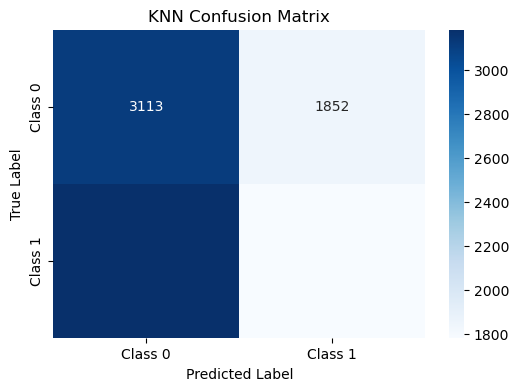

In [200]:
#GridSearchCV for KNN took too much processing power, therefore we will use RandomizedSearchCV
# Define the model
knn_model = KNeighborsClassifier()

# Define hyperparameter grid
param_dist = {
    'n_neighbors': list(range(1, 31)),  # Testing different values for k
    'weights': ['uniform', 'distance'],  # Weighting methods
    'metric': ['euclidean', 'manhattan', 'minkowski']  # Distance metrics
}
X_train_log['SK_ID_CURR']= X_train['SK_ID_CURR']
X_test_log['SK_ID_CURR']= X_test['SK_ID_CURR']
# Apply RandomizedSearchCV with cross-validation
random_search_knn = RandomizedSearchCV(knn_model, param_distributions=param_dist,
                                       n_iter=5, cv=5, scoring='accuracy', n_jobs=-1, random_state=42)
random_search_knn.fit(X_train_log, y_train)  # Corrected train variables *** LOG IMP Features ***

# Best parameters and model
best_knn = random_search_knn.best_estimator_
print(f"Best parameters: {random_search_knn.best_params_}")

# Predict on the test set
y_pred_knn = best_knn.predict(X_test_log)  # Corrected test variable

# Evaluate the KNN model
accuracy_knn = accuracy_score(y_test, y_pred_knn)
print(f"KNN Accuracy: {accuracy_knn:.4f}")
print("KNN Classification Report:")
print(classification_report(y_test, y_pred_knn))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_knn)

# Plot Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("KNN Confusion Matrix")
plt.show()

In this model we are using top 20 predictors from Logistic Regression: 'CODE_GENDER', 'FLAG_OWN_CAR', 'EXT_SOURCE_3_Category', 'DAYS_BIRTH', 'EXT_SOURCE_1_Category', 'FLAG_DOCUMENT_3', 'NAME_EDUCATION_TYPE', 'CNT_PAYMENT_median', 'EXT_SOURCE_2_Category', 'REGION_RATING_CLIENT', 'DAYS_LAST_PHONE_CHANGE', 'AMT_ANNUITY_median', 'FLAG_DOCUMENT_6', 'NAME_CONTRACT_TYPE_<lambda>', 'AMT_ANNUITY', 'DAYS_ID_PUBLISH', 'DEF_30_CNT_SOCIAL_CIRCLE', 'FLOORSMAX_AVG', 'max_num_instalment_version_mean', 'ENOUGH_PAY_<lambda>'.

In general, this model achieves 91.6% accuracy. The model correctly classifies most non-defaulters but fails at detecting defaulters.

Specifically, the confusion metrics are
- Class 0 (Non-Defaulters):
  - True Negatives (correctly classified as non-defaulters): 56,346 
  - False Positives (misclassified as defaulters): 208
- Class 1 (Defaulters):
  - False Negatives (defaulters misclassified as non-defaulters): 4,932 
  - True Positives (correctly classified defaulters): 17

In addition, the model predicts a defaulter correctly 8% of the time (precision class 1 = 0.08). It also detects almost none of the actual defaulters (recall class 1 = 0.00). 

Therefore, this model may have class imbalance issues.

**KNN for X_train_rfc, X_test_rfc**

Best parameters: {'weights': 'uniform', 'n_neighbors': 10, 'metric': 'manhattan'}
KNN Accuracy: 0.4957
KNN Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.64      0.56      4965
           1       0.49      0.35      0.41      4965

    accuracy                           0.50      9930
   macro avg       0.50      0.50      0.49      9930
weighted avg       0.50      0.50      0.49      9930



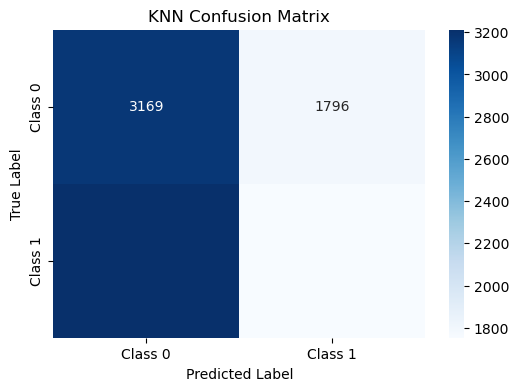

In [203]:
#GridSearchCV for KNN took too much processing power, therefore we will use RandomizedSearchCV
# Define the model
knn_model = KNeighborsClassifier()

# Define hyperparameter grid
param_dist = {
    'n_neighbors': list(range(1, 31)),  # Testing different values for k
    'weights': ['uniform', 'distance'],  # Weighting methods
    'metric': ['euclidean', 'manhattan', 'minkowski']  # Distance metrics
}
X_train_rfc['SK_ID_CURR']= X_train['SK_ID_CURR']
X_test_rfc['SK_ID_CURR']= X_test['SK_ID_CURR']
# Apply RandomizedSearchCV with cross-validation
random_search_knn = RandomizedSearchCV(knn_model, param_distributions=param_dist,
                                       n_iter=5, cv=5, scoring='accuracy', n_jobs=-1, random_state=42)
random_search_knn.fit(X_train_rfc, y_train)  # Corrected train variables *** RFC IMP FEATURES ***

# Best parameters and model
best_knn = random_search_knn.best_estimator_
print(f"Best parameters: {random_search_knn.best_params_}")

# Predict on the test set
y_pred_knn = best_knn.predict(X_test_rfc)  # Corrected test variable

# Evaluate the KNN model
accuracy_knn = accuracy_score(y_test, y_pred_knn)
print(f"KNN Accuracy: {accuracy_knn:.4f}")
print("KNN Classification Report:")
print(classification_report(y_test, y_pred_knn))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_knn)

# Plot Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("KNN Confusion Matrix")
plt.show()

In this model we are using top 20 predictors from Random Forest Classifier: 'CODE_GENDER', 'FLAG_OWN_CAR', 'EXT_SOURCE_3_Category', 'DAYS_BIRTH', 'EXT_SOURCE_1_Category', 'FLAG_DOCUMENT_3', 'NAME_EDUCATION_TYPE', 'CNT_PAYMENT_median', 'EXT_SOURCE_2_Category', 'REGION_RATING_CLIENT', 'DAYS_LAST_PHONE_CHANGE', 'AMT_ANNUITY_median', 'FLAG_DOCUMENT_6', 'NAME_CONTRACT_TYPE_<lambda>', 'AMT_ANNUITY', 'DAYS_ID_PUBLISH', 'DEF_30_CNT_SOCIAL_CIRCLE', 'FLOORSMAX_AVG', 'max_num_instalment_version_mean', 'ENOUGH_PAY_<lambda>'.

In general, this model performs similarly to the first model. However, it made the same mistakes as the above model since they have relatively similar metrics.

**Random Forest with x_train, y_train**

In [ ]:
## random forest model
model_RFC = RandomForestClassifier(class_weight='balanced', random_state=42)
model_RFC.fit(X_train, y_train)

random_predictions = np.random.choice([0, 1], size=y_test.shape[0], p=[0.7, 0.3])

# Calculate accuracy of the random classifier
random_accuracy = accuracy_score(y_test, random_predictions)
print(f"Random Classifier Accuracy: {random_accuracy:.4f}")

With an accuracy of 0.6677, the model can correctly classify around two-thirds of the test samples purely by chance.

**Logistic Regression on x_train, y_train**

In [ ]:
## logistic reg model
# log_model.fit(X_train, y_train)
# Define the logistic model
log_reg = LogisticRegression(max_iter=5000, random_state=42)

# Selecting the Hyper parameters
param_grid = {
    'C': np.logspace(-4, 4, 10),
    'solver': ['liblinear', 'lbfgs']
}

# Apply GridSearchCV with cross-validation
grid_search = GridSearchCV(log_reg, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)  # Updated training variables

# Best parameters and model
best_model = grid_search.best_estimator_
print(f"Best parameters: {grid_search.best_params_}")

# Predict on the test set
y_pred = best_model.predict(X_test)  # Updated test variable

# Evaluating performance
accuracy = accuracy_score(y_test, y_pred)
print(f"Logistic Regression Accuracy: {accuracy:.4f}")
print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Logistic Regression Confusion Matrix")
plt.show()


In general, the model predicts 90.75% of the time. However, from the confusion matrix and classification report scores, it can be seen that this logistic regression model makes the same mistakes as the above two models.

In [ ]:
# ROC CURVE
# Get predicted probabilities from the trained model
y_train_preds_proba = best_model.predict_proba(X_train)[:, 1]  # Use only probabilities for class 1

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_train, y_train_preds_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})', color='blue')
plt.plot([0,1], [0,1], linestyle='--', color='gray')  # Diagonal baseline
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


In [ ]:
roc_auc

In [ ]:
# Improvement vs randomly guessing
ROC = roc_auc
guess = 0.50

round((ROC - guess)/guess,2)

The ROC is 0.70. This means compared to randomly guessing the model performs 40% better

**Test Set**

After selecting the best model, we will use it for the application_test set and submit on Kaggle competition. Our public Kaggle score and ranking is 0.50039 and 6912 respectively.

We apply the same data cleaning process to test set. However, since there are some missing columns between train and test set, we use lightbgm to predict the values of those columns. 

In [ ]:
# application_test_df
summary = application_test_df.describe()
display(summary)
print(application_test_df.shape)

In [ ]:
application_test_clean = application_test_df.copy()
reduce_memory_usage(application_test_clean)
factorize_EXT_SOURCE(application_test_clean)
bin_CAR_AGE(application_test_clean)
fill_OCCUPATION_col(application_test_clean)
standardize_children_col(application_test_clean)

cap_outliers_sd(application_test_df, exclude_columns = ['CNT_CHILDREN', 'TARGET'])
application_test_clean.shape

There are some missing columns between the training data and the test data so used lightbgm model to predict the values of those columns

In [ ]:
cat_cols_test = factorize_cat_cols(application_test_clean)

# Identify missing columns in test data
missing_cols = [col for col in X_train_rfc.columns if col not in application_test_clean.columns]

# Identify common features (present in both train & test datasets)
common_features = list(set(X_train_rfc.columns) & set(application_test_clean.columns))

# Copy test data
application_test_final = application_test_clean.copy()

# Add missing columns from train dataset (fill with NaNs initially)
for col in missing_cols:
    application_test_final[col] = np.nan

# Predict missing columns using LightGBM
for col in missing_cols:
    print(f"Predicting missing column: {col}")

    # Define features (X) and target (y) in train dataset
    X_train1 = X_train_rfc[common_features]
    y_train1 = X_train_rfc[col]

    # Remove NaNs from training data (since target column may have some NaNs)
    valid_idx = ~y_train1.isna()
    X_train1, y_train1 = X_train1[valid_idx], y_train1[valid_idx]

    # Split train-validation to avoid overfitting
    X_tr, X_val, y_tr, y_val = train_test_split(X_train1, y_train1, test_size=0.2, random_state=42)

    # Define and train LightGBM model
    model = lgb.LGBMRegressor(n_estimators=100, learning_rate=0.07, random_state=42)
    model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)])

    # Predict missing column values in test dataset
    application_test_final[col] = model.predict(application_test_final[common_features])

# Save the updated test dataset
application_test_final.to_csv("test_predicted1.csv", index=False)

print("Missing columns predicted successfully using LightGBM!")


In [ ]:
test_df = pd.read_csv("test_predicted1.csv")
test_rfc_df = test_df.copy()
# Convert the test columns to match the data types of the training columns
for column in X_train_rfc.columns:
    if column in test_rfc_df.columns:
        test_rfc_df[column] = test_rfc_df[column].astype(X_train_rfc[column].dtype)

# Check if there are missing values in the test set
print("Missing values in test set:")
print(test_rfc_df.isna().sum())

# Fill missing values with 0 or use any other strategy
test_rfc_df.fillna(0, inplace=True)

In [ ]:
# Ensure 'SK_ID_CURR' is added to test data
test_rfc_df['SK_ID_CURR'] = test_df['SK_ID_CURR']

# First ensure all columns from X_train_rfc are in test_rfc_df
for col in X_train_rfc.columns:
    if col not in test_rfc_df.columns:
        test_rfc_df[col] = 0  # Or np.nan or other appropriate default

# Reorder columns to match X_train_rfc
test_rfc_df = test_rfc_df[X_train_rfc.columns]

scaler = StandardScaler()
scaler.fit(X_train_rfc[numerical_columns])
# Ensure all numerical columns are of the same type
numerical_columns = [col for col in test_rfc_df.columns if col not in cat_cols_test and col != 'SK_ID_CURR']
test_rfc_df[numerical_columns] = test_rfc_df[numerical_columns].astype(float)

# Now apply scaling
test_rfc_df[numerical_columns] = scaler.transform(test_rfc_df[numerical_columns])

# Predict on the prepared test data
predictions = best_knn.predict(test_rfc_df)

# Add predictions to a new dataframe
output_df = pd.DataFrame({
    'SK_ID_CURR': test_df['SK_ID_CURR'],
    'target': predictions
})

# Save to CSV
output_df.to_csv('Submission.csv', index=False)
print("Prediction complete and saved to submission.csv.")

<a id="12"></a> 
### c. Findings


In this section, we will visualize the relationships between top 5 predictors in our best model with the target variables using countplot function. Below are the findings:
- Males are more prone to default than females.
- Applicants without a car are more likely to default compared to those who own a car
- A lack of external information from source 3 often results in a higher risk of repayment difficulties
- The differences between the different levels of education and default are not strongly correlated, but there are still noticeable differences among them.
- Younger borrowers typically face more challenges with repayment

In [ ]:
# Creating a function to place top predictors in a dataframe
# Get feature names
feature_names = X_train.columns

# Extract coefficients
coefficients = best_model.coef_.flatten()  # Convert to 1D array

# Create a DataFrame with predictors and their coefficients
important_predictors = pd.DataFrame({
    'Predictor': feature_names,
    'Coefficient': coefficients,
    'Abs_Coefficient': np.abs(coefficients)  # Take absolute values
})

# Sort by absolute coefficient value (most important features first)
important_predictors = important_predictors.sort_values(by='Abs_Coefficient', ascending=False)

# Display the DataFrame
print(important_predictors.head(20))  # Show top 20 predictors


In [ ]:
# Creating a Function to plot predictors in relation to Target
def countplot_function(df, column, hue="TARGET", figsize=(10, 5), rotation=90):
    """
    Plots a countplot with percentage labels on each bar.

    Parameters:
    - df (pd.DataFrame): DataFrame containing the data
    - column (str): Column to visualize
    - hue (str): Hue for grouping (default is "TARGET")
    - figsize (tuple): Figure size (default is (10,5))
    - rotation (int): Rotation angle for x-axis labels (default is 90)
    """
    if column not in df.columns:
        raise ValueError(f"Column '{column}' not found in DataFrame.")
    if hue and hue not in df.columns:
        raise ValueError(f"Hue '{hue}' not found in DataFrame.")

    plt.figure(figsize=figsize)

    # Compute percentages within each group
    grouped = df.groupby(column)[hue].value_counts(normalize=True).mul(100).rename("percentage").reset_index()

    # Create countplot using `hue`
    ax = sns.barplot(data=grouped, x=column, y="percentage", hue=hue)

    # Annotate bars with percentage labels
    for p in ax.patches:
        percentage = f'{p.get_height():.1f}%'  # Format as percentage
        ax.annotate(percentage, (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='baseline', fontsize=10, color='black',
                    xytext=(0, 5), textcoords='offset points')

    # Rotate x-axis labels
    plt.xticks(rotation=rotation)

    # Change y-axis label to percentage
    plt.ylabel("Percentage (%)")

    plt.show()

In [ ]:
#First is CODE_GENDER
countplot_function(merged_final_df, 'CODE_GENDER')

The factorized gender of 0 (male) is more likely to have trouble in repayment compare to 1(female).

In [ ]:
#Second is FLAG_OWN_CAR
countplot_function(merged_final_df, 'FLAG_OWN_CAR')

Applicants owning no car have a higher chance (slightly) of having repaying trouble than those who own a car.

In [ ]:
#Third is EXT_SOURCE_3_Category
countplot_function(merged_final_df, 'EXT_SOURCE_3_Category')

Having no external information from external source 3 tends to place this group at a higher risk of repayment difficulty.

In [ ]:
#Fourth is NAME_EDUCATION_TYPE
countplot_function(merged_final_df, 'NAME_EDUCATION_TYPE')

The differences between values are not highly correlative, but there are still noticeable differences between them.

In [ ]:
#Fifth is how DAYS_BIRTH affected repaying ability
def kdeplot_by_target(df, numeric_column, target_column="TARGET", figsize=(10,5)):
    plt.figure(figsize=figsize)
    sns.kdeplot(data=df, x=numeric_column, hue=target_column, fill=True)
    plt.xlabel(numeric_column)
    plt.ylabel("Density")
    plt.title(f"KDE Plot of {numeric_column} by {target_column}")
    plt.show()


kdeplot_by_target(merged_final_df, 'DAYS_BIRTH')

Younger borrowers tend to have more trouble in repayment, and that eases out as borrower profile gets older.

<a id="13"></a> 
# 3. Conclusion

In this notebook, we aimed to build a predictive model to assess loan repayment ability for unbanked customers of Home Credit. Through extensive data cleaning, feature engineering and data preprocessing, we build 3 machine learning models and choose KNN to be the best-performing one. In general, the model predicts correctly around 90% of the time, but performs poorly on detecting the default clients. Since the cost of misclassification may lead to billions of dollars in losses for Home Credit, this remains a critical issue.

The model suggests that the top 5 most important predictors for default are CODE_GENDER, FLAG_OWN_CAR, EXT_SOURCE_3_Category, NAME_EDUCATION_TYPE and DAYS_BIRTH. We also observed significant differences between defaulters and non-defaulters based on these variables. In addition, despite thorough feature engineering, only a few of these variables are selected as strong predictors for the default problem. This suggests that our team should look further into different ways of featuring variables. 

Furthermore, all model suggests bias to the majority class due to class imbalance issues even though we already downsampled and scaled the data to prevent bias. It is important to investigate further into this problem. It could be attributed to the preprocessing process.

Due to limited time, we were unable to further fine-tune the model. Future work could involve applying more feature engineering and testing out different machine learning models such as XGBoost. We can also refer to the work of the Kaggle winner's competition to identify more important features and optimize our model's performance.

<a id="14"></a> 
# 4. Group Member Contribution

Sudeeptha Sivarajan - EDA, created all the functions for cleaning data and streamlined the process, RFC modelling, worked with test data, predicted missing columns using lightbgm model and made kaggle submissions

Hung Duong - EDA, features engineer on the Previous_application.csv, application_train.csv and the POS_CASH_balance. Downsampled the Previous_application.csv and aggregated it on the SK_ID_CURR level. Then join with POS_CASH_balance and join again with Previous_application.csv on the SK_ID_PREV column. Plot the top most correlated preditors on the TARGET column.


Linh Do - EDA, features engineer on bureau.csv, bureau_balance.csv, installment_payments.csv, credit_card_balance.csv and join them with application_train. Documenting the notebook for Canvas submission

Ali Ladha - KNN modelling, Hyperparameter Tuning (GridSearchCV/RandomSearchCV), Confusion matrix implementation, ROC curve, adding Linhs code for bureau analysis onto the final model. Fixing CNT_Children variable via capping. Creating function to cap numeric outliers within +/- 3SD of mean. Pasting team functions onto the final file. Adding teams summary statistics and data exploration graphs.


**We would also like to express our sincere gratitude to Professors Jeff Webb and David Agogo for their invaluable guidance throughout the Capstone project!**